In [2]:
import numpy as np
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
import random
import glob
from matplotlib import rc
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

from ohiaGAOfunctions import importData, specFill, getMeanSD, pca, plotPC, explVar

# Plotting Parameters


In [13]:
plt.rcParams.update({'font.size': 16})

site = ['YL', 'YH', 'ML', 'MH', 'OL', 'OH']
site_full = ['Young-Low', 'Young-High', 'Medium-Low', 'Medium-High', 'Old-Low', 'Old-High']

cramp = ['#FFAF01', '#CC8B00', '#3333FF', 'midnightblue','#3ACF3A','forestgreen']
line = ['solid', 'dashed','solid', 'dashed','solid', 'dashed']

# Chems


In [3]:
chems_list = [                                                                
'B',                                                                              
'Ca',                                                                             
'Car',                                                                            
'Cellulose',                                                                      
'TotChl',                                                                         
'Fe',                                                                             
'K',                                                                              
'Lignin',                                                                         
'LMA',                                                                            
'Mg',                                                                             
'N',                                                                              
'P',                                                                              
'Phenols',                                                                        
'SolC',                                                                           
'TotC',                                                                           
'Water']

chems_list_full = [                                                                
'Boron',                                                                              
'Calcium',                                                                             
'Carotenoids',                                                                            
'Cellulose',                                                                      
'Chlorophyll',                                                                         
'Iron',                                                                             
'Potassium',                                                                              
'Lignin',                                                                         
'LMA',                                                                            
'Magnesium',                                                                             
'Nitrogen',                                                                              
'Phosphorus',                                                                              
'Phenols',                                                                        
'Soluble Carbon',                                                                           
'Total Carbon']

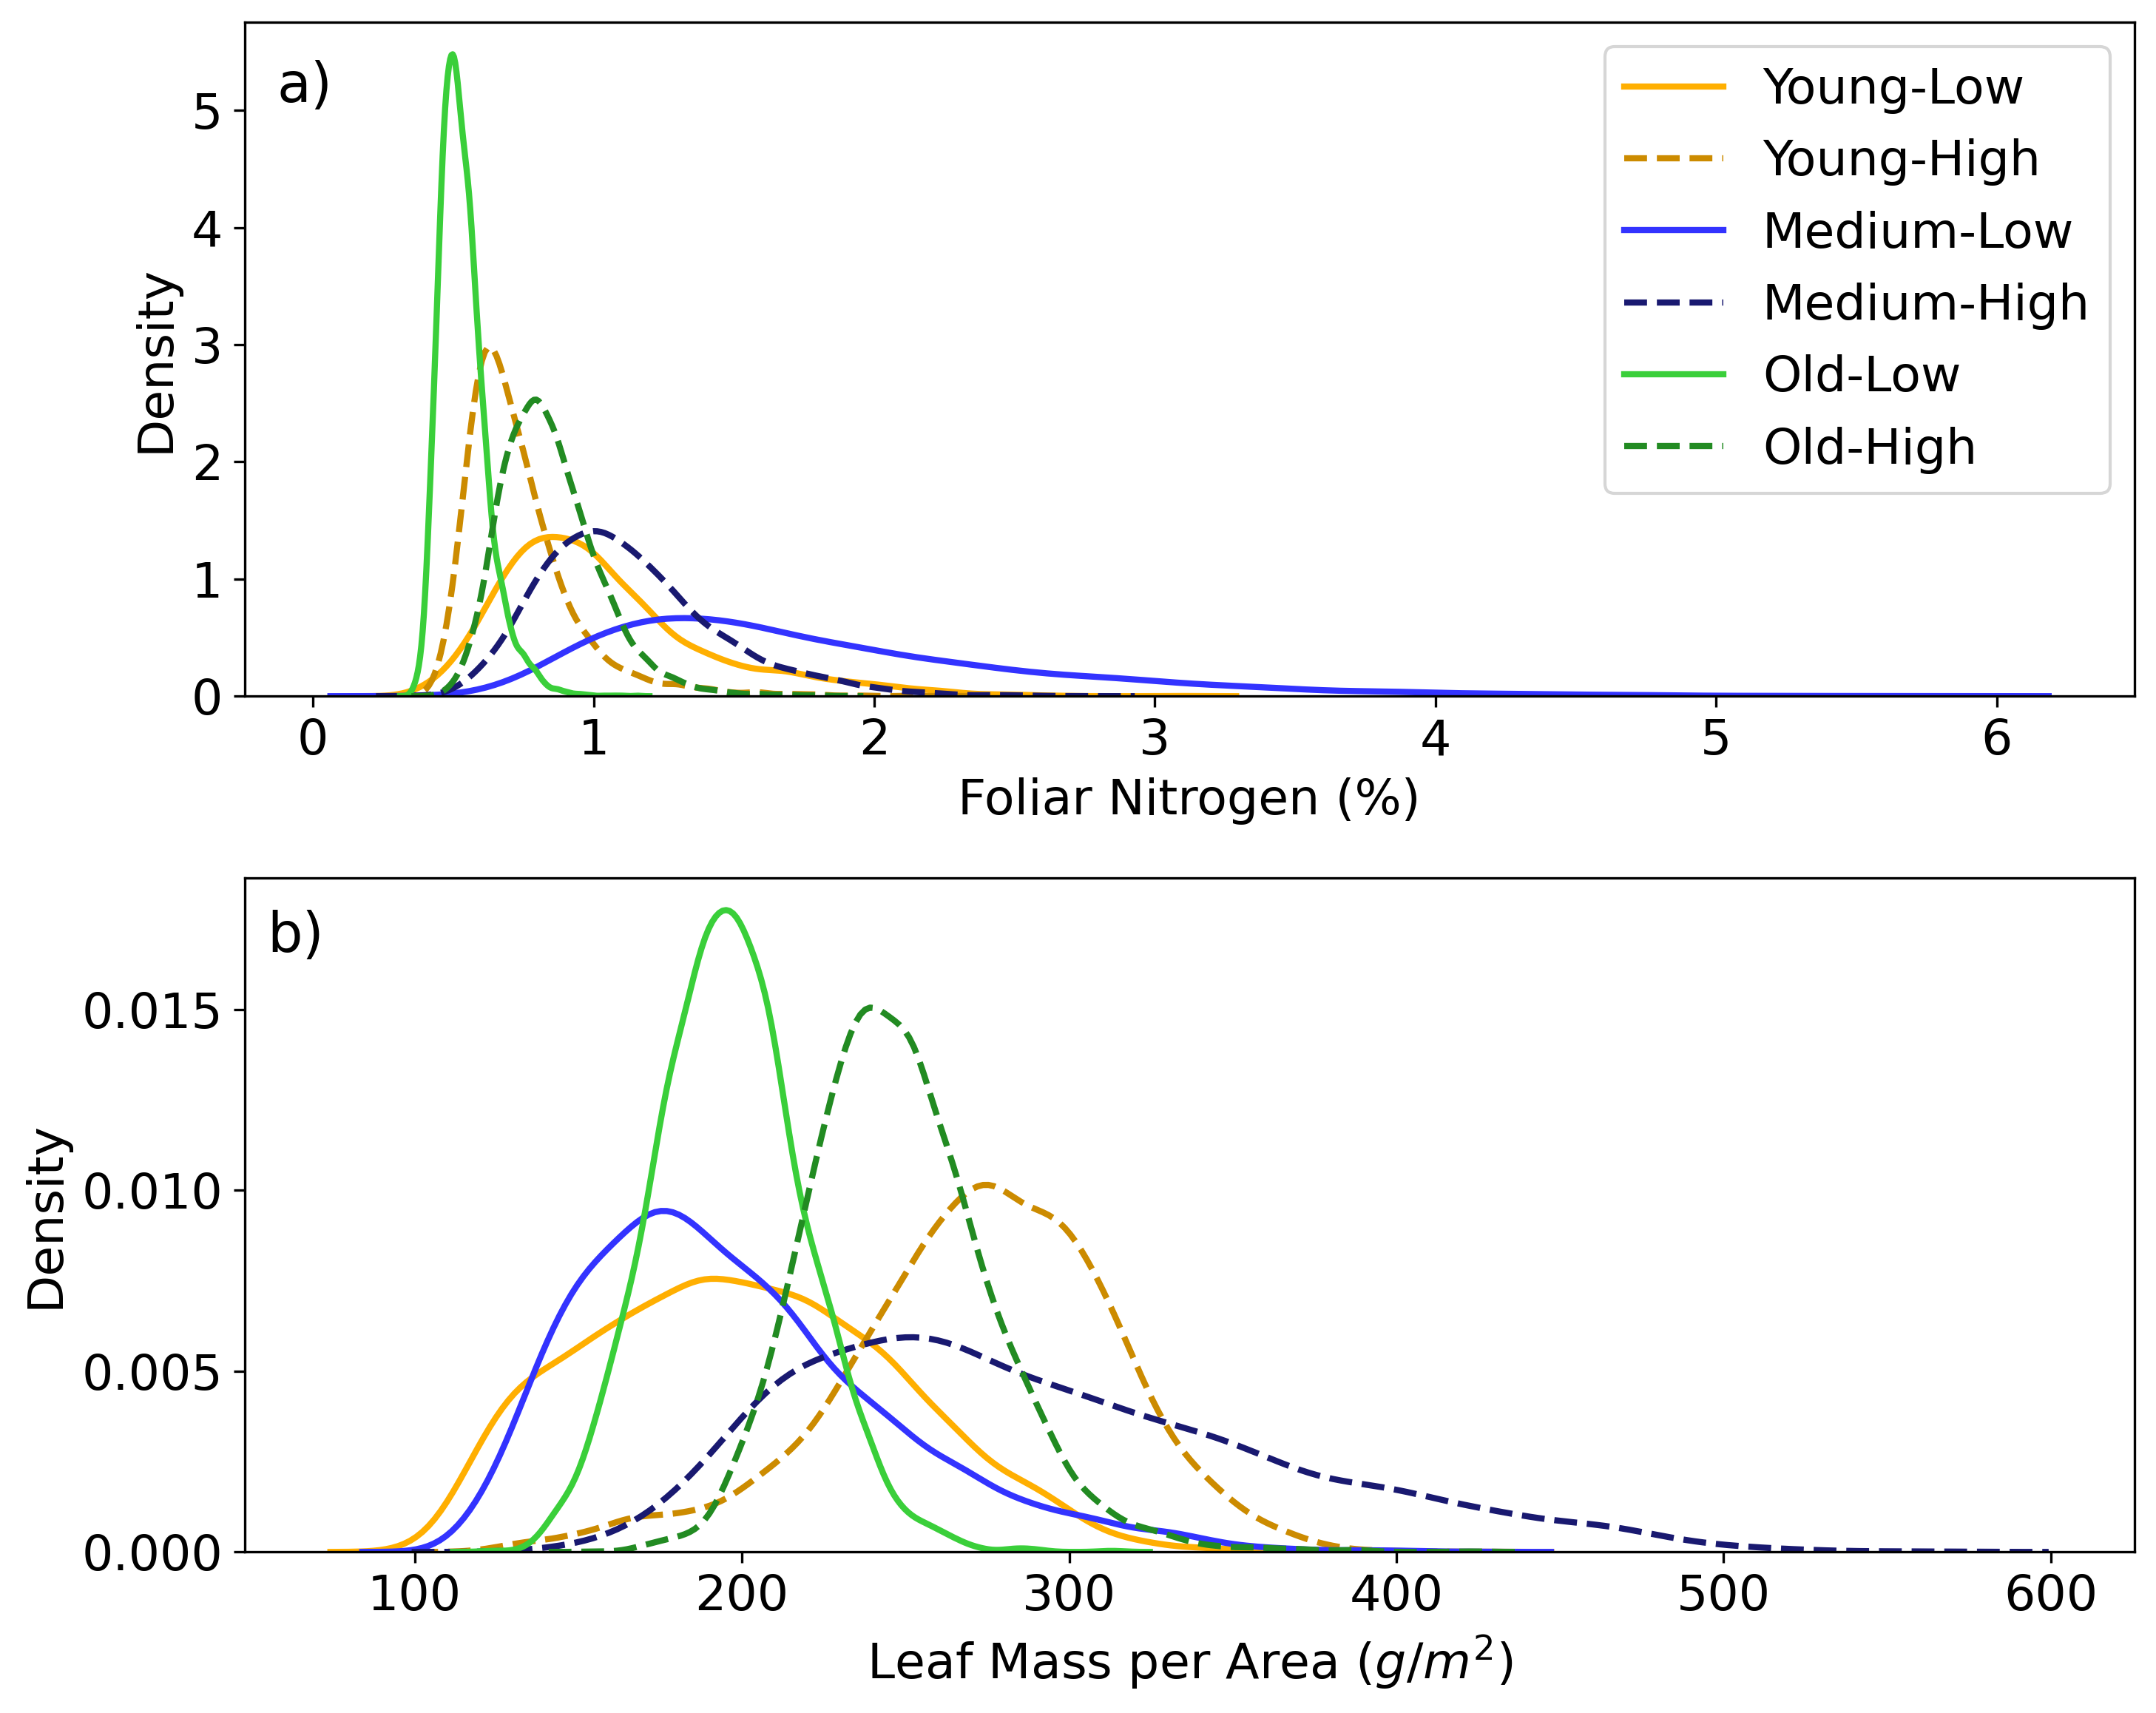

In [5]:
fig, axs = plt.subplots(2, figsize = (10, 8), dpi = 300)

for i, j in enumerate (site):

    chem = rasterio.open(glob.glob(f'data/filtered_2m/{j}_filtered_chem.tif')[0])
    n = chem.read(11)
    n = n[n!=-9999]
    plotted = n[sorted(random.sample((range(n.shape[0])), 7000))]

    sns.distplot(plotted, hist = False, kde=True, color = cramp[i],
                 kde_kws={'linewidth': 2, 'linestyle':line[i]}, ax = axs[0],
                label = site_full[i])
    

    lma = chem.read(9)
    lma = lma[lma!=-9999]
    plotted = lma[sorted(random.sample((range(n.shape[0])), 7000))]
    
    sns.distplot(plotted, hist = False, kde=True,
                 color = cramp[i],
             kde_kws={'linewidth': 2, 'linestyle':line[i]}, ax = axs[1])
    
    
axs[0].legend()
axs[0].text(-0.128,5.07,'a)', fontsize = 18)
axs[1].text(55,.0166,'b)', fontsize = 18)

axs[0].set_xlabel('Foliar Nitrogen (%)')
axs[1].set_xlabel(r'Leaf Mass per Area ($g/m^2$)')


fig.tight_layout()

Text(-0.8, 3100, 'Frequency')

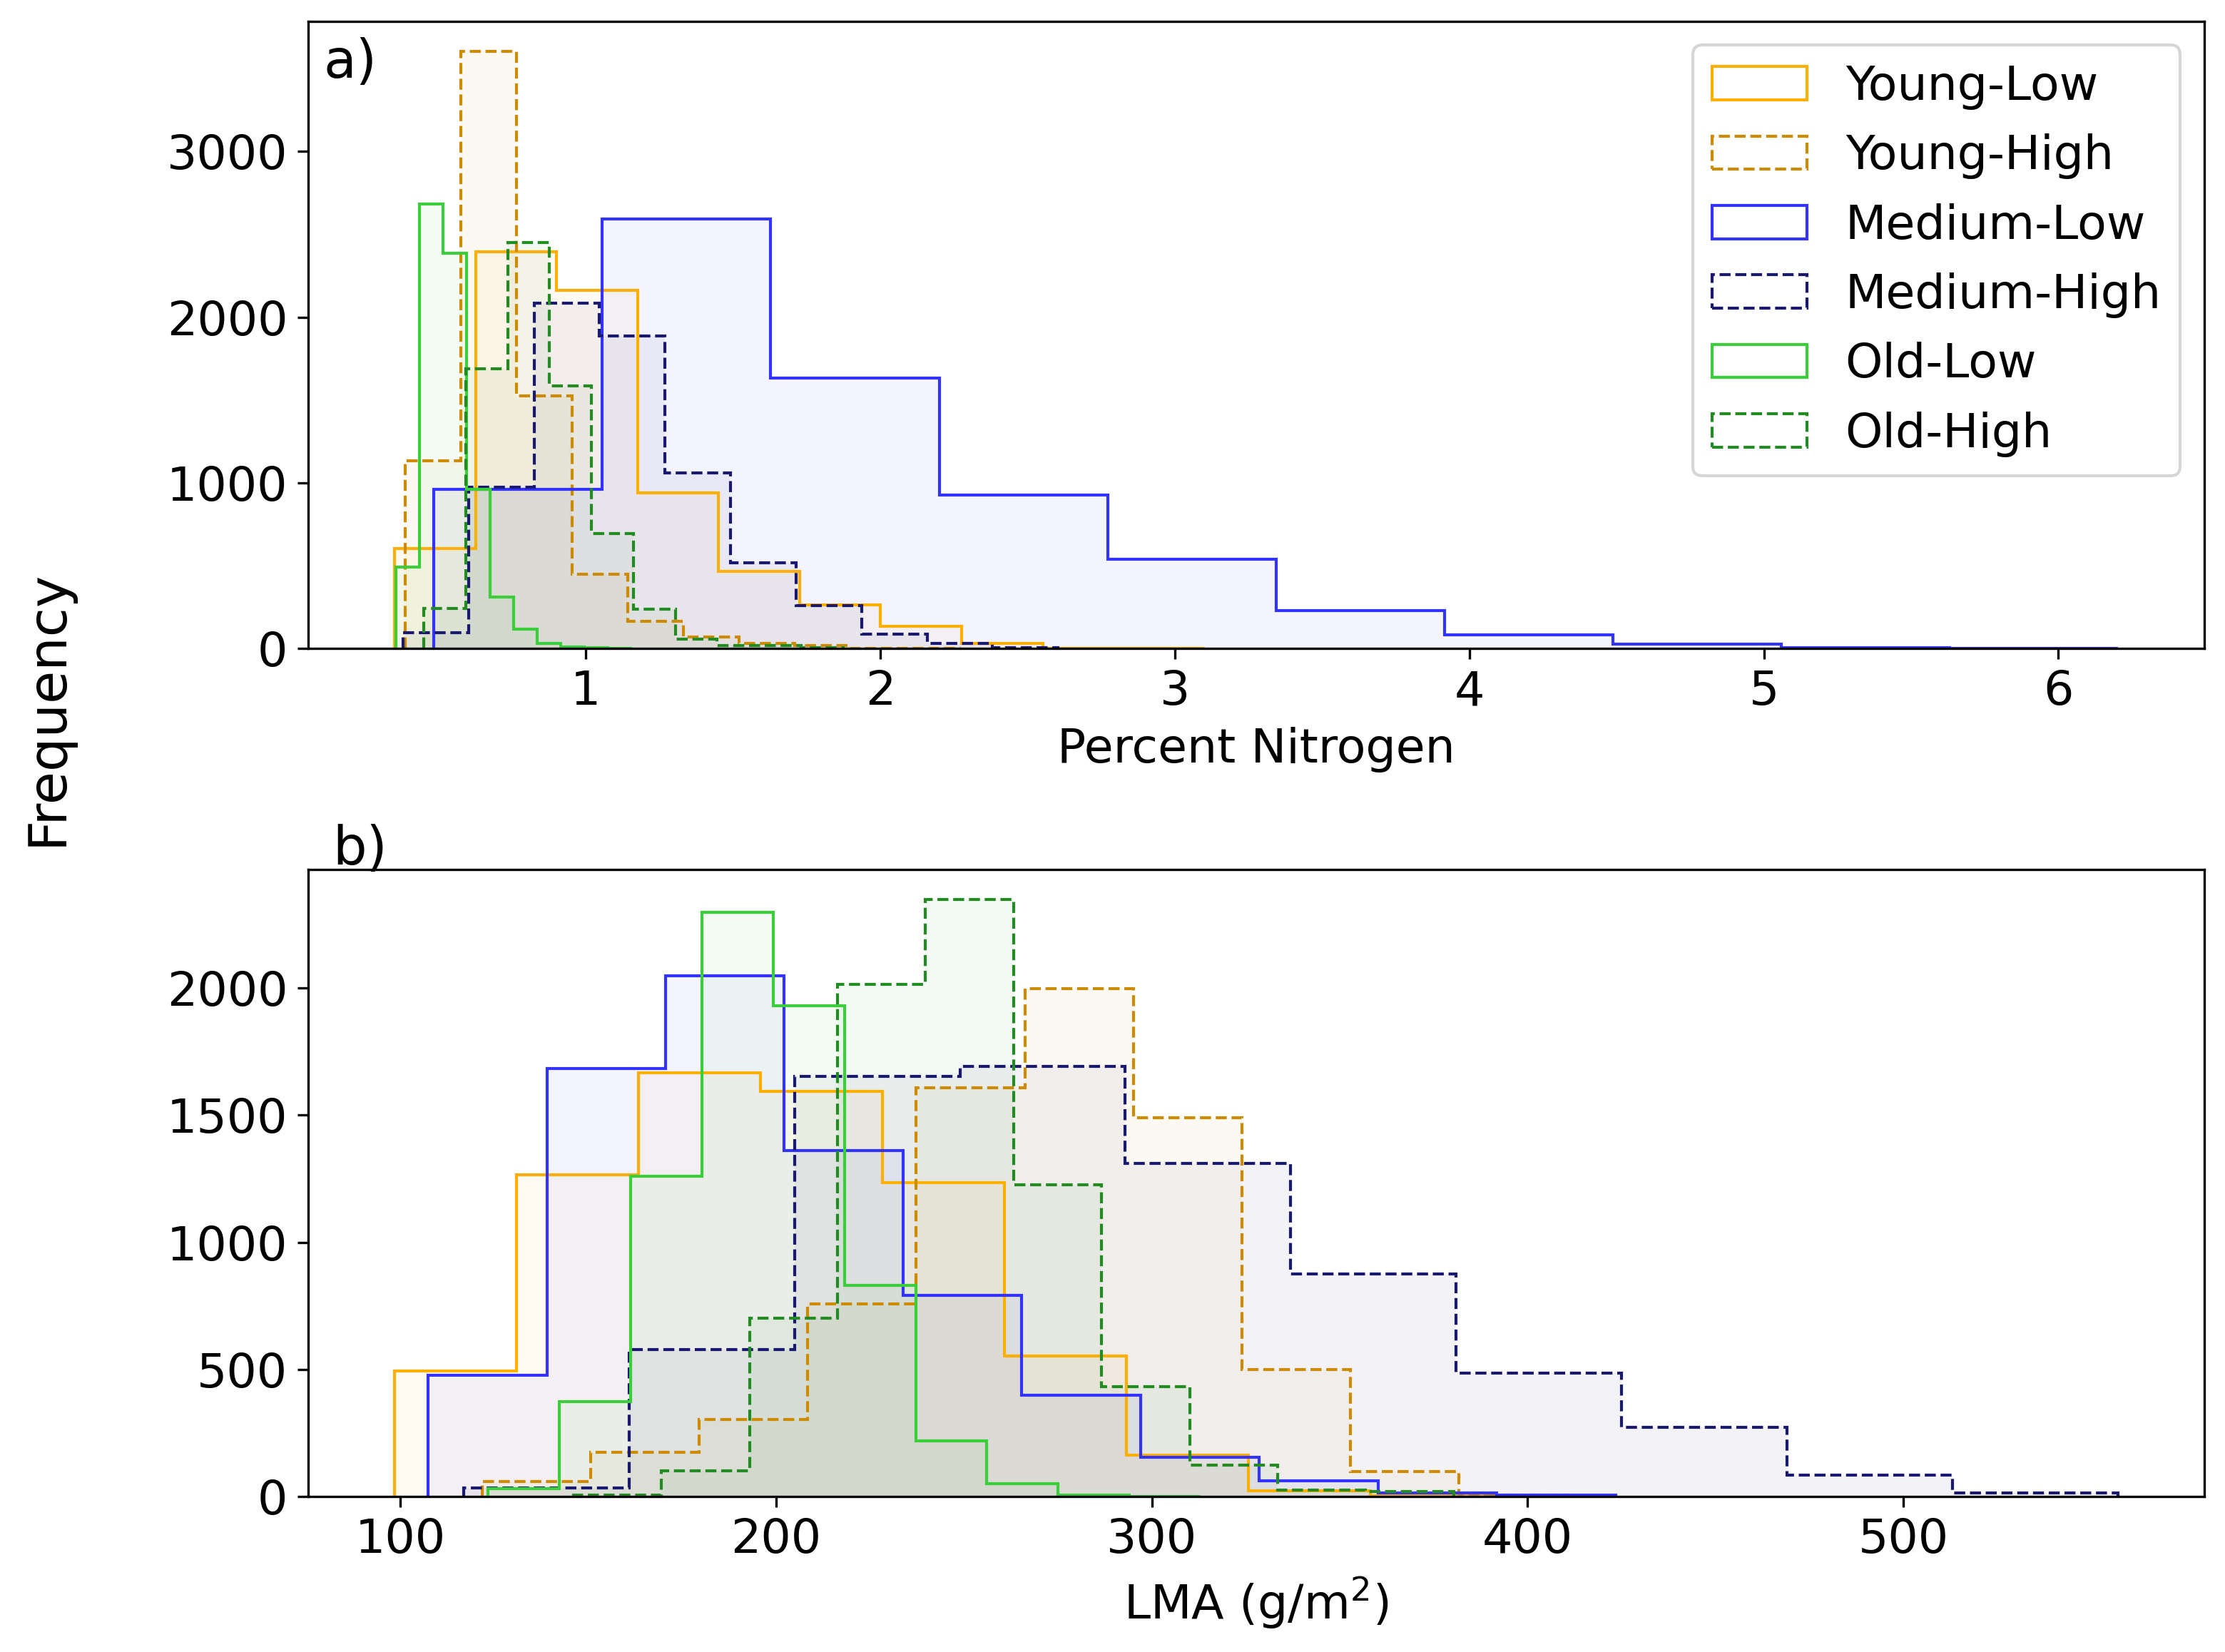

In [8]:
fig, axs = plt.subplots(2, figsize = (10, 8), dpi = 300)

for i, j in enumerate (site):
    chem = rasterio.open(glob.glob(f'data/filtered_2m/{j}_filtered_chem.tif')[0])
    n = chem.read(11)
    n = n[n!=-9999]
    plotted = n[sorted(random.sample((range(n.shape[0])), 7000))]
    counts, bins = np.histogram(plotted)
    axs[0].hist(bins[:-1], bins, weights=counts, color = cramp[i], fill = False, histtype='step', linestyle = line[i], label = site_full[i])
    axs[0].hist(bins[:-1], bins, weights=counts, color = cramp[i], alpha = 0.05,  linestyle = line[i])

axs[0].set_xlabel('Percent Nitrogen')


for i, j in enumerate (site):
    chem = rasterio.open(glob.glob(f'data/filtered_2m/{j}_filtered_chem.tif')[0])
    lma = chem.read(9)
    lma = lma[lma!=-9999]
    counts, bins = np.histogram(lma[sorted(random.sample((range(lma.shape[0])), 7000))])
    axs[1].hist(bins[:-1], bins, weights=counts, color = cramp[i], fill = False, histtype='step', linestyle = line[i])
    axs[1].hist(bins[:-1], bins, weights=counts, color = cramp[i], alpha = 0.05,  linestyle = line[i])
axs[1].set_xlabel('LMA (g/m$^2$)')
plt.rcParams.update({'font.size': 16})

axs[0].legend()
axs[0].text(0.11,3445,'a)', fontsize = 18)
axs[1].text(82,2486,'b)', fontsize = 18)

fig.tight_layout(w_pad = 0.1)
plt.text(-0.8,3100, 'Frequency', va='center', rotation='vertical', fontsize = 18)



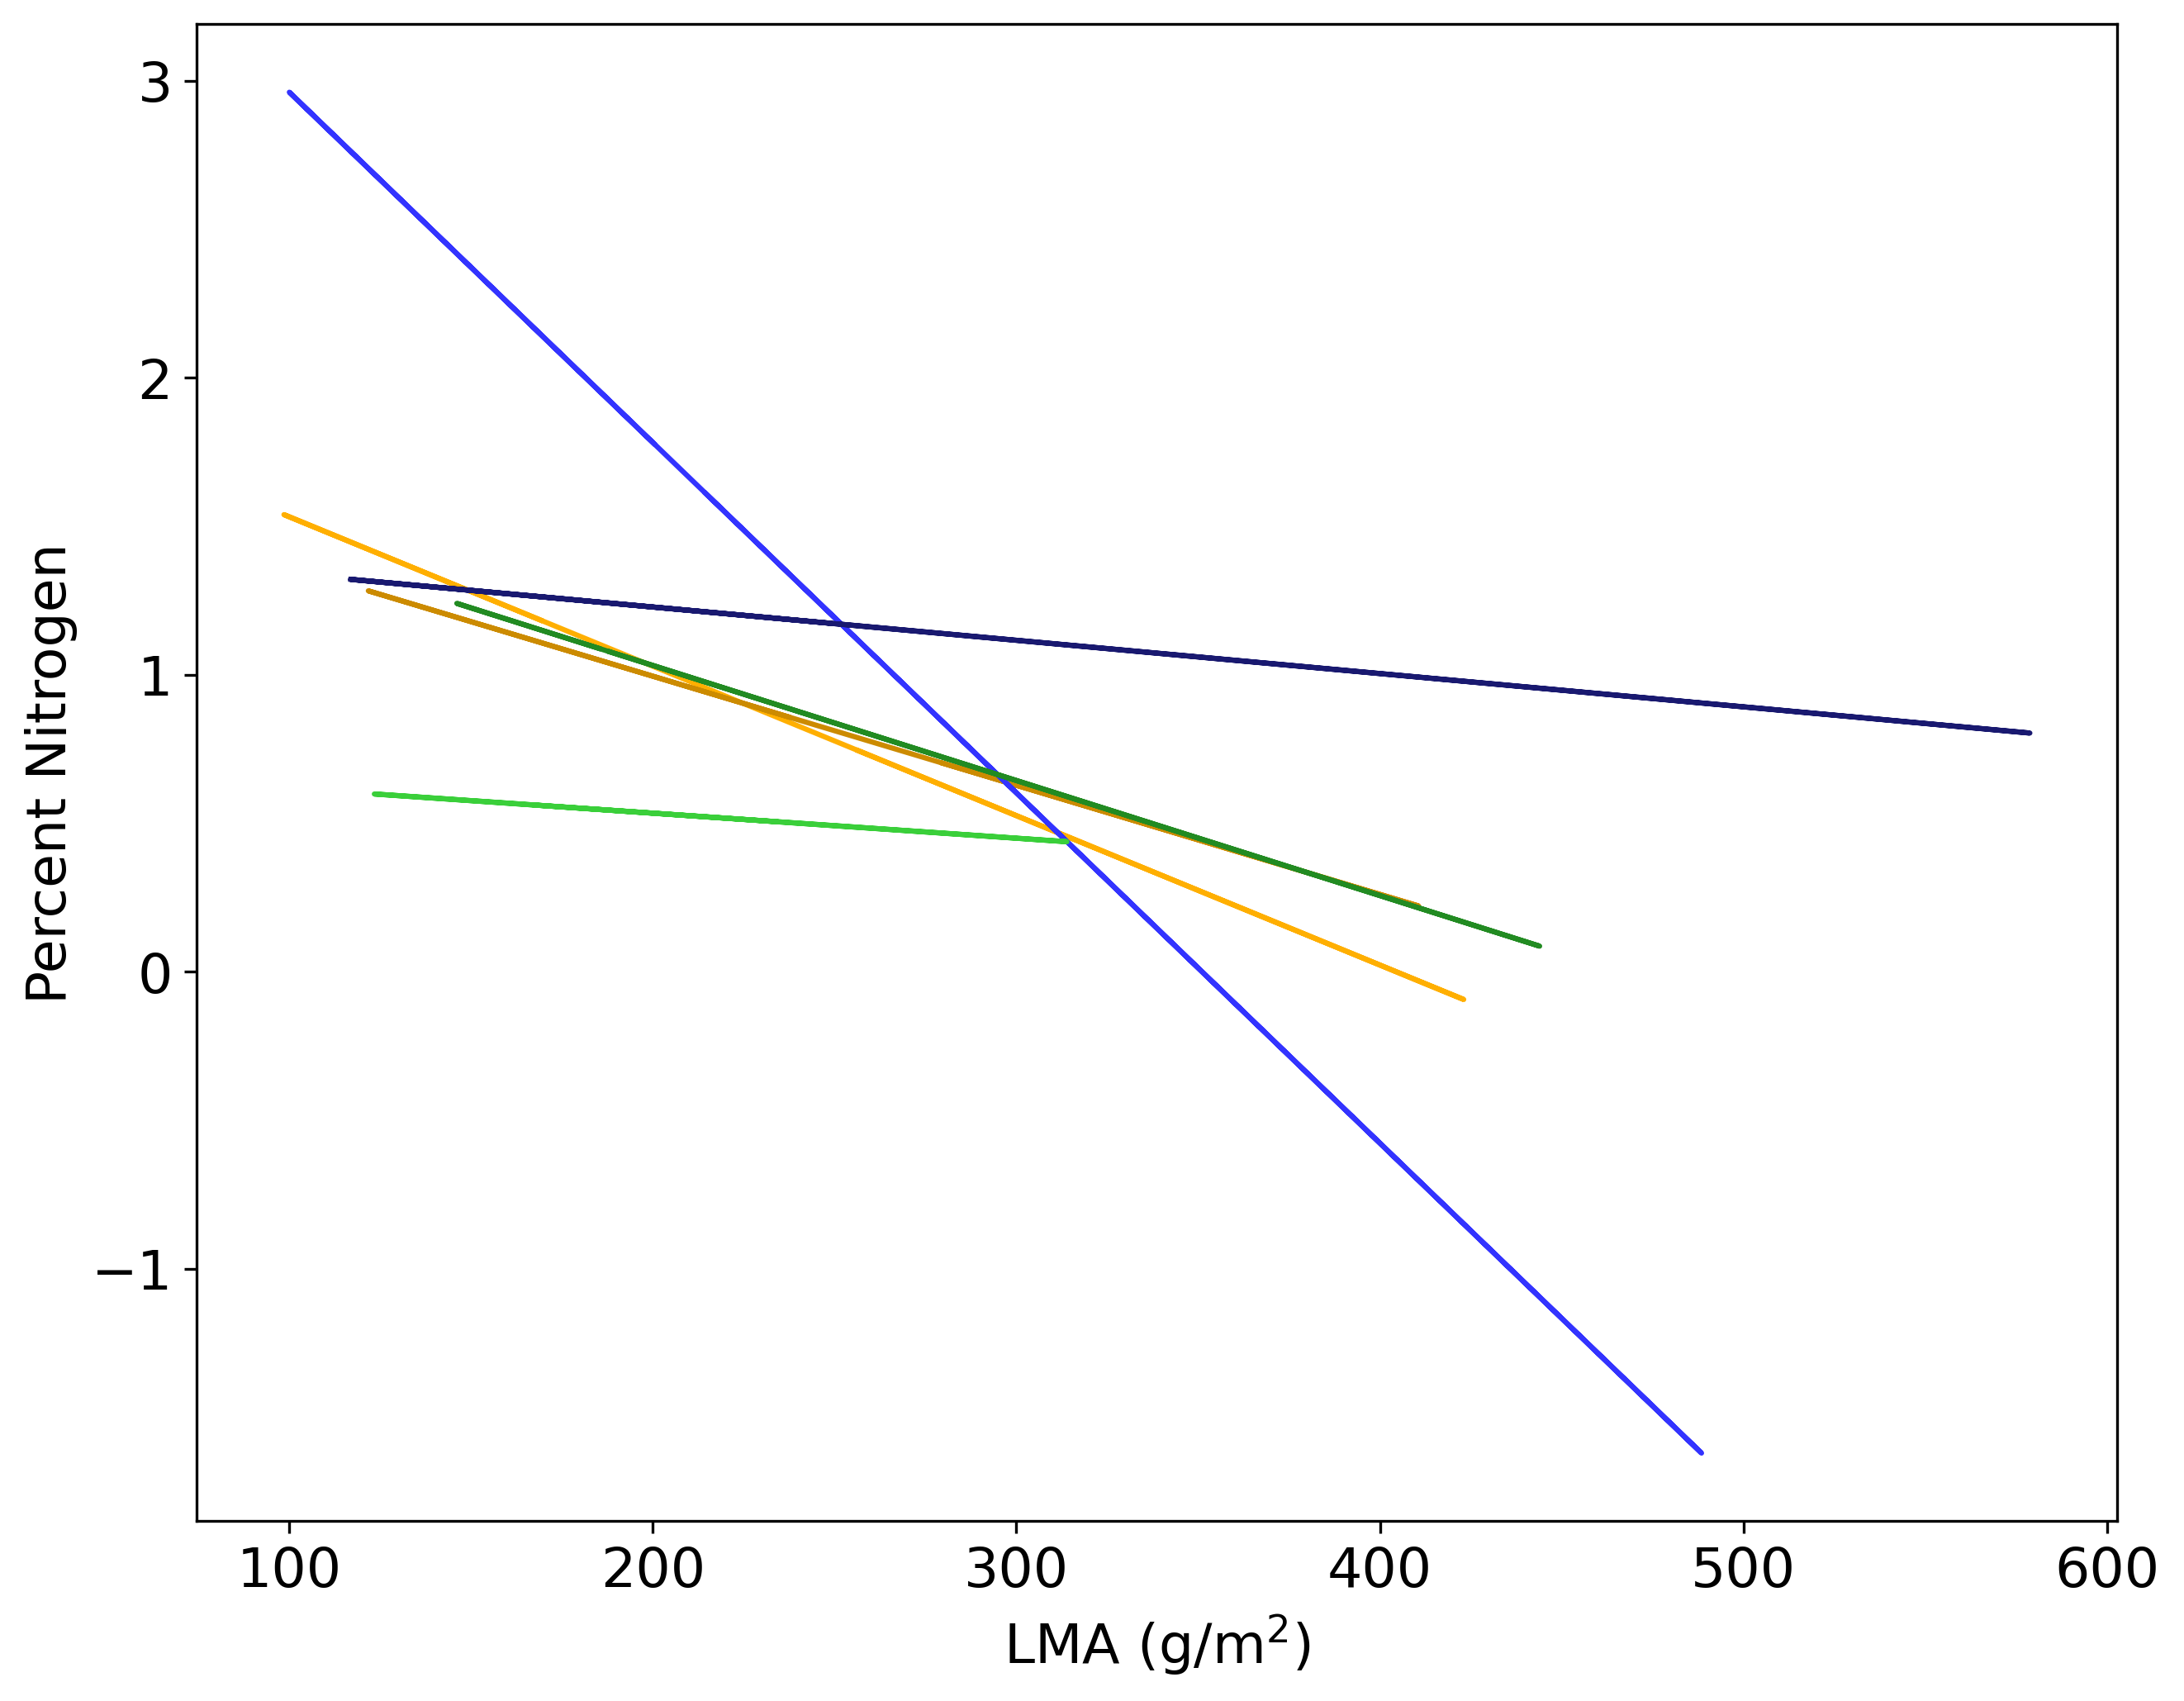

In [6]:
fig, axs = plt.subplots(1, figsize = (10, 8), dpi = 300)


for i, j in enumerate (site):
    chem = rasterio.open(glob.glob(f'data/{j}/chems/{j}_filtered_chem.tif')[0])
    n = chem.read(11)
    n = n[n!=-9999]
    
    lma = chem.read(9)
    lma = lma[lma!=-9999]
    
    m, b = np.polyfit(lma, n, 1)
    
    axs.plot(lma, m*lma + b, color = cramp[i])
#     axs.scatter(lma, n, alpha = 0.01, color = cramp[i])

axs.set_ylabel('Percent Nitrogen')
axs.set_xlabel('LMA (g/m$^2$)')

plt.rcParams.update({'font.size': 16})


In [4]:
use = [2,3,5,6,9,11,12,14,15]

def importChems(site):
    
    # Reshape data (flatten to 2d) and remove no data
    
    # 1 through 16 removes water 
    for b in use:
        tmpdat = site.read(indexes=[b])
        tmpdat = tmpdat.reshape(tmpdat.shape[0],-1)
        tmpdat = tmpdat[tmpdat != -9999]
        tmpdat = tmpdat[tmpdat != np.nan]
        tmpdat = tmpdat.reshape(1,tmpdat.shape[0])
        if (b == 2):
            fullDat = tmpdat
        else:
            fullDat = np.append(fullDat, tmpdat, axis =0)
    return fullDat

# Import filtered data, remove water bands, and normalize
YL_chem = importChems(rasterio.open('data/unfiltered_2m/ASU_GAO_YL_WKOP2019_preu_chems_ndvi07'))
YH_chem = importChems(rasterio.open('data/unfiltered_2m/ASU_GAO_YH_Havo2019_preu_chems_ndvi07'))
ML_chem = importChems(rasterio.open('data/unfiltered_2m/ASU_GAO_ML_Honokaa2019_preu_chems_ndvi07'))
MH_chem = importChems(rasterio.open('data/unfiltered_2m/ASU_GAO_MH_Hakalau2019_preu_chems_ndvi07'))
OL_chem = importChems(rasterio.open('data/unfiltered_2m/ASU_GAO_OL_Kohala2019_preu_chems_ndvi07'))
OH_chem = importChems(rasterio.open('data/unfiltered_2m/ASU_GAO_OH_ParkerRanch_preu_chems_ndvi07'))


YL_len = YL_chem.shape[1]
YH_len = YH_chem.shape[1]
ML_len = ML_chem.shape[1]
MH_len = MH_chem.shape[1]
OL_len = OL_chem.shape[1]
OH_len = OH_chem.shape[1]

In [10]:
OL_chem.shape

(9, 13642)

In [29]:
importChems(rasterio.open('data/unfiltered_2m/ASU_GAO_YH_Havo2019_preu_chems_ndvi07')).shape

(15, 7474)

In [79]:
minPix = min((YL_len, 
                      YH_len,
                     ML_len,
                     MH_len,
                     OL_len,
                     OH_len))

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from bioinfokit.analys import get_data
from bioinfokit.visuz import cluster

ModuleNotFoundError: No module named 'bioinfokit'

In [12]:
YL_chem.shape

(15, 7564)

In [14]:
minPix

7394

In [44]:
all_chem = np.hstack((YL_chem[:,sorted(random.sample((range(YL_chem.shape[1])), minPix))],
                    YH_chem[:,sorted(random.sample((range(YH_chem.shape[1])), minPix))],
                    ML_chem[:,sorted(random.sample((range(ML_chem.shape[1])), minPix))],
                    MH_chem[:,sorted(random.sample((range(MH_chem.shape[1])), minPix))],
                    OL_chem[:,sorted(random.sample((range(OL_chem.shape[1])), minPix))],
                    OH_chem[:,sorted(random.sample((range(OH_chem.shape[1])), minPix))]))

chem_pca, chem_v = pca(StandardScaler().fit_transform(all_chem))

In [69]:
all_chem.shape

(9, 44844)

In [105]:
chem_pca.shape

(9, 44844)

In [11]:
# col = np.concatenate(((np.repeat('red',minPix)), 
#                      (np.repeat('darkred',minPix)),
#                     (np.repeat('blue',minPix)),
#                     (np.repeat('midnightblue',minPix)),
#                     (np.repeat('limegreen',minPix)),
#                     (np.repeat('forestgreen',minPix))))

# plotPC(chem_pca, [2,1,0], col)

In [12]:
# X_st=StandardScaler().fit_transform(all_chem)
# pca_out = PCA().fit(X_st)
# loadings = pca_out.components_
# pca_out.explained_variance_

In [13]:
# p = PCA()
# pca_scores = p.fit_transform(X_st)
# # cluster.biplot(cscore=pca_out, loadings=loadings, labels=col, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
# #     var2=round(pca_out.explained_variance_ratio_[1]*100, 2))


In [14]:
# y = cramp
# def myplot(score,coeff,labels=None):
#     xs = score[:,0]
#     ys = score[:,1]
#     n = coeff.shape[0]
# #     scalex = 1.0/(xs.max() - xs.min())
# #     scaley = 1.0/(ys.max() - ys.min())
# #     plt.scatter(xs * scalex,ys * scaley)
#     for i in range(n):
#         plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
#         if labels is None:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
#         else:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
# #     plt.xlim(-1,1)
# #     plt.ylim(-1,1)
#     plt.xlabel("PC{}".format(1))
#     plt.ylabel("PC{}".format(2))
#     plt.grid()

# myplot(pca_scores[:,0:2],np.transpose(p.components_[0:2, :]))
# plt.show()

In [46]:
minPix = min((YL_len, 
                      YH_len,
                     ML_len,
                     MH_len,
                     OL_len,
                     OH_len))

pcCent = []
pcSD = []

for n in range(9): 
    start = 0
    end = minPix
    pc_mean = []
    pc_sd = []
    for i, j in enumerate(site):
        pc_mean = np.append(pc_mean, chem_pca[n, start:end].mean())
        pc_sd = np.append(pc_sd, chem_pca[n, start:end].std())
        start = start + minPix
        end = end + minPix
    if n == 0:
        pcCent = pc_mean
        pcSD = pc_sd
    else:
        pcCent = np.vstack((pcCent, pc_mean))
        pcSD = np.vstack((pcSD, pc_sd))

In [76]:
pcCent_sub.shape

(8, 6)

In [77]:
pcCent_sub = pcCent[:,:]

for i in range(5):
    for j in range(1,6):
        if i != j:
            dist = np.linalg.norm(pcCent_sub[:,i] - pcCent_sub[:,j])
            print(site[i],"-", site[j], " : ", round(dist*100))

YL - YH  :  34
YL - ML  :  61
YL - MH  :  18
YL - OL  :  61
YL - OH  :  14
YH - ML  :  90
YH - MH  :  25
YH - OL  :  46
YH - OH  :  22
ML - YH  :  90
ML - MH  :  72
ML - OL  :  115
ML - OH  :  72
MH - YH  :  25
MH - ML  :  72
MH - OL  :  63
MH - OH  :  10
OL - YH  :  46
OL - ML  :  115
OL - MH  :  63
OL - OH  :  55


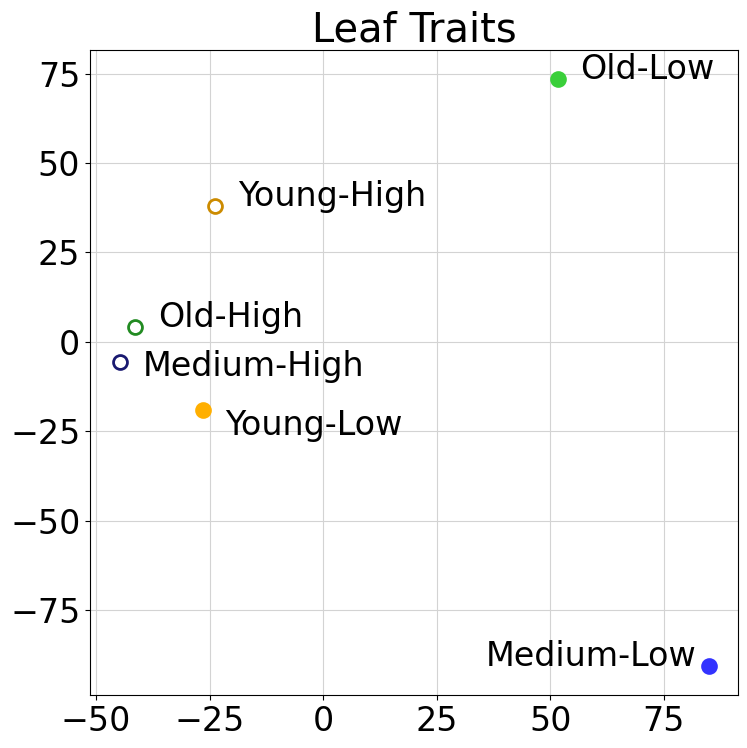

In [101]:
D = np.array([
    [0, 34, 61, 18,61,14],
    [34,0,90,25,46,22],
    [61,90,0,72,115,72],
    [18,25,72,0,63,10],
    [61,46,115,63,0,55],
    [14,22,72,10,55,0]])

mfc = ['#FFAF01', 'w', '#3333FF', 'w','#3ACF3A','w']
# Modified from code by David R Thompson
import pylab as plt
from sklearn.manifold import MDS
plt.rcParams.update({'font.size': 24})
fig, axs = plt.subplots(ncols = 1, figsize = (8,8))

# Define distance matrix
# D = np.array([
#     [0, 77, 102, 120,20,58],
#     [77,0,126,74,74,41],
#     [102,126,0,102,118,89],
#     [120,74,102,0,126,64],
#     [20,74,118,126,0,63],
#     [58,41,89,64,63,0]])



# Fit a multidimensional scaling transform (nonlinear)
# Project to two dimensions, preserving interpoint distances
mds = MDS(2, random_state = 198)
x=mds.fit_transform(D)

# Plot the labels
for i,label in enumerate([ 'Young-Low', 'Young-High', 'Medium-Low', 'Medium-High', 'Old-Low', 'Old-High']):
    axs.plot(x[i,0],x[i,1],'.', 
                markersize=20, 
                color = cramp[i], 
                markerfacecolor = mfc[i],
               markeredgewidth=2)
    if i == 2:
        axs.text(x[i,0]-49,x[i,1],label)
    elif i == 3:
        axs.text(x[i,0]+5,x[i,1]-4,label)
    elif i == 0:
        axs.text(x[i,0]+5,x[i,1]-7,label)
    else:
        axs.text(x[i,0]+5,x[i,1],label)

    
# axs.set_xlim((-100, 50))
# axs.set_ylim((-100, 50))
# axs.set_aspect('equal')
# axs[0].box(True)
axs.grid(True, color = 'lightgray')
axs.set_title('Chemistry PCA')
# axs.set_ylim(-80,30)
# axs.set_xlim(-20,40)


    
plt.tight_layout()




# axs.set_aspect('equal')

axs.set_title('Leaf Traits')
# axs[1].set_box(True)
axs.grid(False, color = 'lightgray')
# axs.text(-107,134,'b)', fontsize = 18)

    
plt.tight_layout()

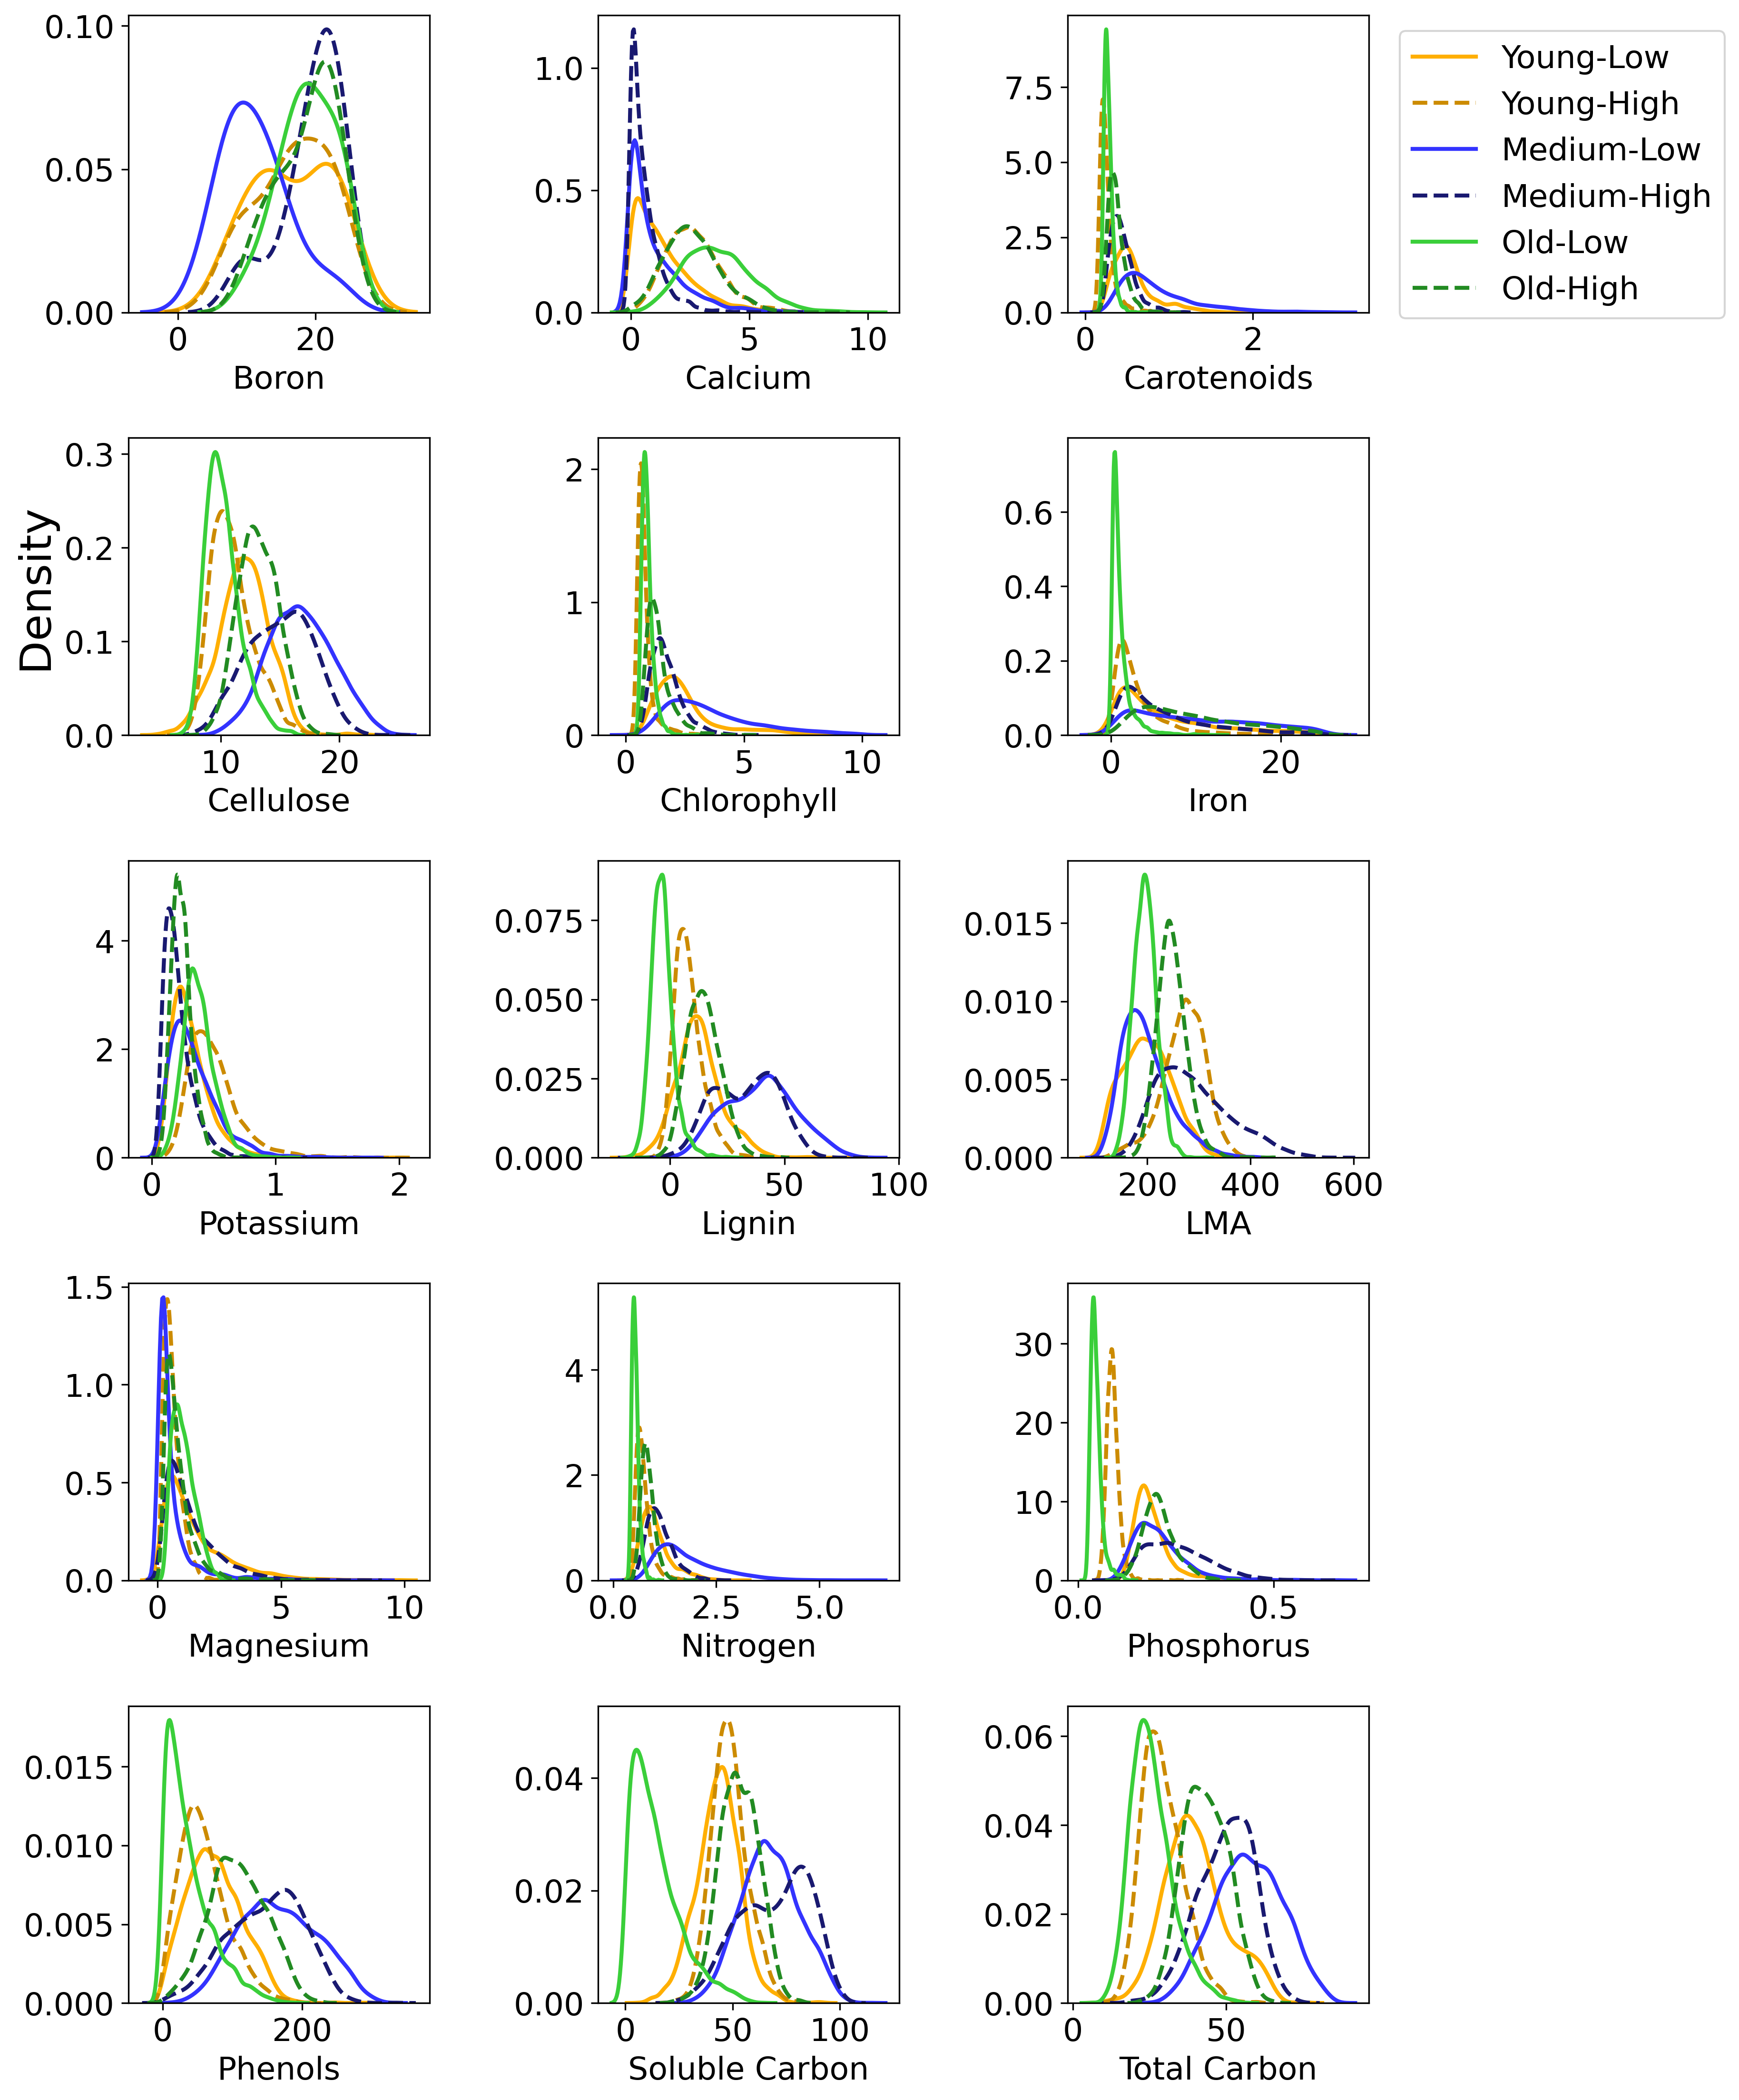

In [18]:


chems_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

# chems_num = np.arange(2,16)
fig, axs = plt.subplots(5,3, figsize = (10, 15), dpi = 300)


row = 0
col = 0
cnt = 1

for c in chems_num:

    for i, j in enumerate (site):
        chem = rasterio.open(glob.glob(f'data/{j}/chems/{j}_filtered_chem.tif')[0])
        chem_in = chem.read(c)
        chem_in = chem_in[chem_in!=-9999]
        
        if c == 6:
            chem_in = chem_in[chem_in<25]
        if c == 2:
            chem_in = chem_in[chem_in<10]
            
        if c == 3:
            chem_in = chem_in[chem_in<3]
        if c == 5:
            chem_in = chem_in[chem_in<10]
        if c == 10:
            chem_in = chem_in[chem_in<10]
        if c == 12:
            chem_in = chem_in[chem_in<0.8]
        if c == 13:
            chem_in = chem_in[chem_in>=0]
        if c == 14:
            chem_in = chem_in[chem_in>=0]
        if c == 1:
            chem_in = chem_in[chem_in<25]
            chem_in = chem_in[sorted(random.sample((range(chem_in.shape[0])), 17))]
        else:
        
            chem_in = chem_in[sorted(random.sample((range(chem_in.shape[0])), 4700))]
        
        sns.distplot(chem_in, hist = False, kde=True, 
                 bins=int(180/5), color = cramp[i], 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2, 'linestyle':line[i]}, ax = axs[row,col],
                label = site_full[i])

    axs[row,col].set_xlabel(chems_list_full[c-1])
    axs[row,col].set_ylabel(None)
    
    plt.rcParams.update({'font.size': 16})

# #     axs.legend()


#     plt.text(-0.8,3100, 'Frequency', va='center', rotation='vertical', fontsize = 18)

    if (cnt % 3 == 0) :
        row = row+1
        col = 0
        cnt = 1
    else: 
        col = col+1
        cnt = cnt+1

fig.tight_layout()
axs[1,0].set_ylabel("Density", size = 22)



axs[0,2].legend(bbox_to_anchor=(1.05, 1))

In [68]:

chems_list_full2 = [                                                                
'Boron', 'Boron',                                                                             
'Calcium','Calcium',                                                                             
'Carotenoids','Carotenoids',                                                                            
'Cellulose','Cellulose',                                                                      
'Chlorophyll','Chlorophyll',                                                                         
'Iron','Iron',                                                                             
'Potassium','Potassium',                                                                              
'Lignin','Lignin',                                                                         
'LMA','LMA',                                                                            
'Magnesium','Magnesium',                                                                             
'Nitrogen', 'Nitrogen',                                                                              
'Phosphorus', 'Phosphorus',                                                                              
'Phenols','Phenols',                                                                        
'Soluble Carbon',  'Soluble Carbon',                                                                           
'Total Carbon','Total Carbon']


chems_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

# chems_num = np.arange(2,16)

chems_stat = pd.DataFrame(columns=chems_list_full2, index = site)

cnt = 0

for c in chems_num:
    
    for i, j in enumerate (site):
        chem = rasterio.open(glob.glob(f'data/{j}/chems/{j}_filtered_chem.tif')[0])
        chem_in = chem.read(c)
        chem_in = chem_in[chem_in!=-9999]
        
        if c == 6:
            chem_in = chem_in[chem_in<25]
        if c == 2:
            chem_in = chem_in[chem_in<10]
            
        if c == 3:
            chem_in = chem_in[chem_in<3]
        if c == 5:
            chem_in = chem_in[chem_in<10]
        if c == 10:
            chem_in = chem_in[chem_in<10]
        if c == 12:
            chem_in = chem_in[chem_in<0.8]
        if c == 13:
            chem_in = chem_in[chem_in>=0]
        if c == 14:
            chem_in = chem_in[chem_in>=0]
        if c == 1:
            chem_in = chem_in[chem_in<25]
            chem_in = chem_in[sorted(random.sample((range(chem_in.shape[0])), 17))]
        else:
        
            chem_in = chem_in[sorted(random.sample((range(chem_in.shape[0])), 4700))]
        
        m = np.mean(chem_in)
        v = np.std(chem_in)
        
        chems_stat.iloc[i,cnt] = m
        chems_stat.iloc[i,cnt+1] = v

    cnt = cnt + 2
    
chems_stat.to_csv('images/chems_stats.csv')


In [ ]:


chems_num = [2,3,4,5,6,7,8,10,12,13,14,15]
site_c = [YL_chem, YH_chem, ML_chem, MH_chem, OL_chem, OH_chem]

fig, axs = plt.subplots(3,4, figsize = (10, 8), dpi = 300)


row = 0
col = 0
cnt = 1

for c in chems_num:

    for i, j in enumerate (site_c):
        chem_in = j[c-1,:]
        

#         plotted = chem_in[sorted(random.sample((range(n.shape[0])), 7000))]
        if c == 6:
            chem_in = chem_in[chem_in<25]
        
        print(i)
        if i == 0:
            chem_np = chem_in
        elif i == 1:
            chem_plt = pd.DataFrame([chem_np, chem_in])
        else:
            chem_plt = chem_plt.append(pd.DataFrame(chem_in))
            
        if i == 5:
            sns.boxplot(chem_plt, color = cramp[i], ax = axs[row,col])

    axs[row,col].set_xlabel(chems_list[c-1])
    axs[row,col].set_ylabel(None)
    
    plt.rcParams.update({'font.size': 16})

# #     axs.legend()


#     plt.text(-0.8,3100, 'Frequency', va='center', rotation='vertical', fontsize = 18)

    if (cnt % 4 == 0) :
        row = row+1
        col = 0
        cnt = 1
    else: 
        col = col+1
        cnt = cnt+1

fig.tight_layout()
axs[1,0].set_ylabel("Density", size = 22)



axs[0,3].legend(bbox_to_anchor=(1.05, 1))

0
1
2


In [4]:
print(site)

['YL', 'YH', 'ML', 'MH', 'OL', 'OH']


# Canopy Height and Elev

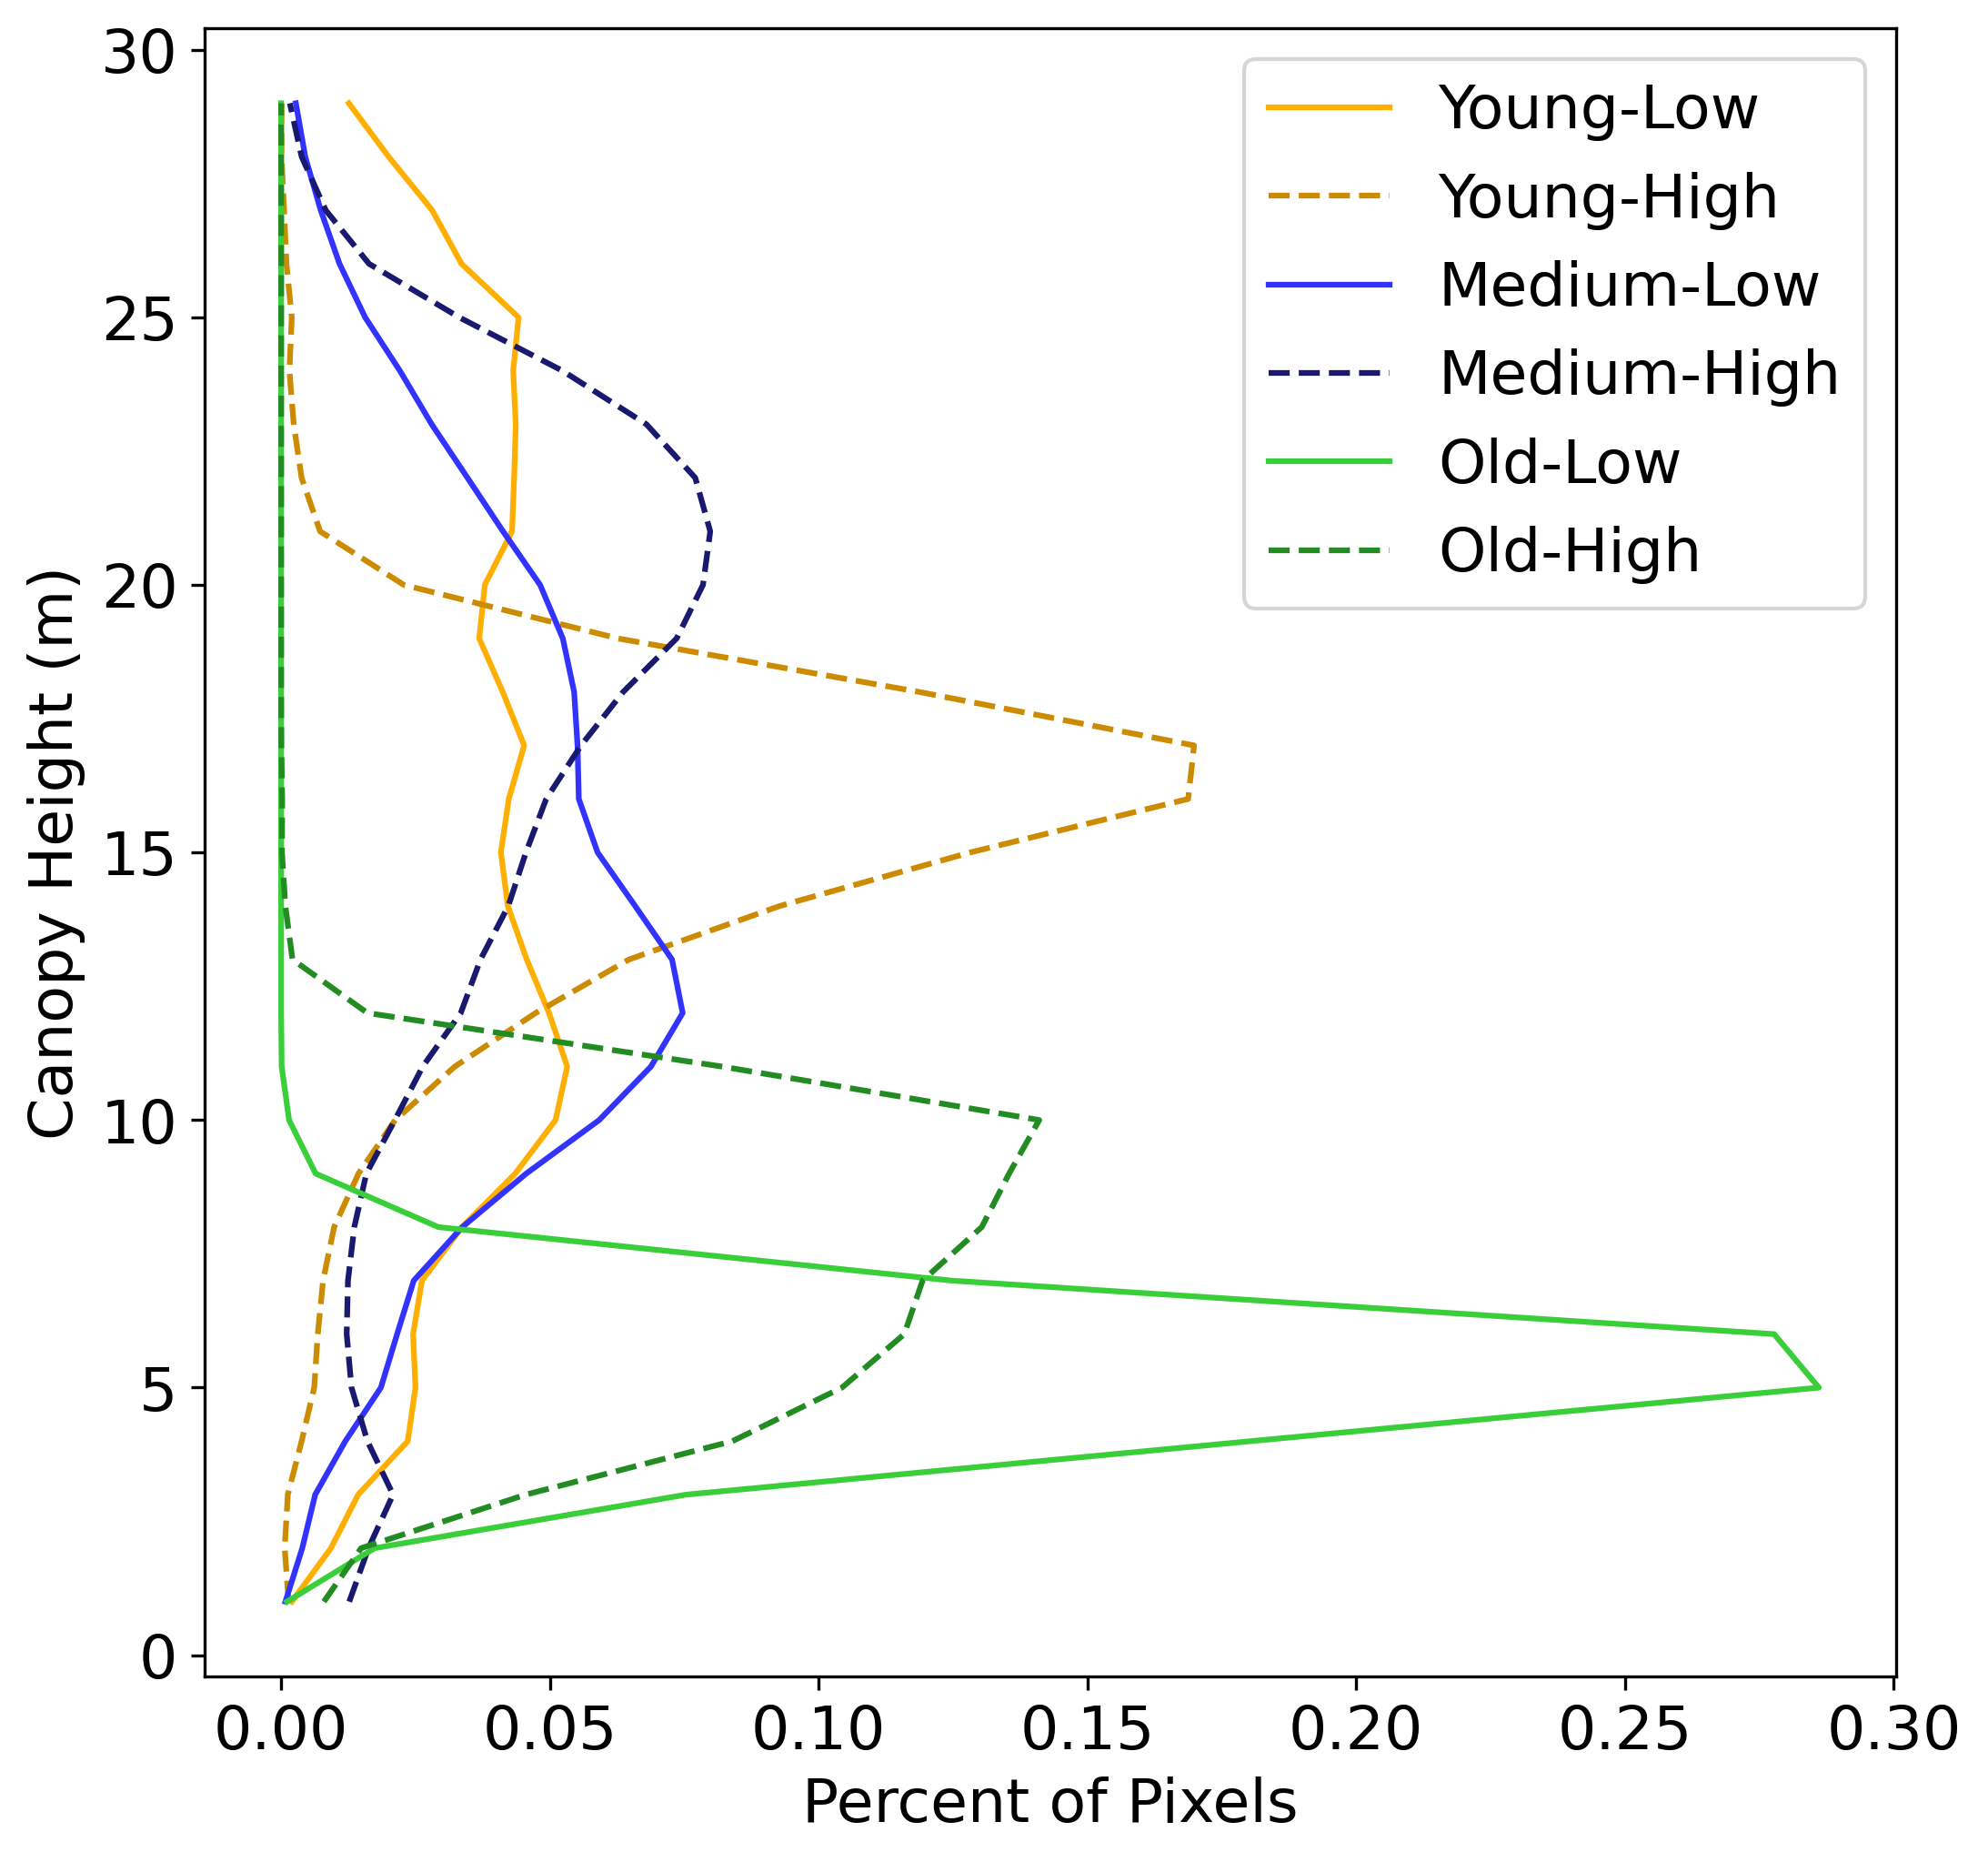

In [50]:
plt.figure(figsize=(8,8), dpi = 300)
for i, j in enumerate(site):
    pathtch = glob.glob('data/tch/*'+j+'*tch*.tif')

    tch = rasterio.open(pathtch[0]).read()
    tch_flat = tch.flatten()
    tch_flat = tch_flat[tch_flat>0]
    
    h = np.histogram(tch_flat, bins=np.arange(30), density=True)
    plt.plot(h[0],h[1][1:], label = site_full[i], c = cramp[i], linestyle = line[i])

plt.xlabel('Percent of Pixels')
plt.ylabel('Canopy Height (m)')
plt.legend()
plt.show()

# Plot mean and sd with varying mask thresholds

In [13]:
def plotSpectraSensitivity(site, folder, maskType, heightSens):
    plt.figure(figsize=(8,8))
    path = glob.glob('data/'+site+'/orig/*_refl.tif')
    refl = rasterio.open(path[0])
    refl =  refl.read()
    
    refl_arr = refl.astype('float')
    refl_arr[refl == -9999] = np.nan # or use np.nan
    mean_refl = np.nanmean(refl_arr, axis=(1,2))

    pathMask = glob.glob('data/'+site+'/orig/*'+maskType+'.tif')
    mask = rasterio.open(pathMask[0])
    mask = mask.read()
    
    for i in range(0, len(heightSens)):
        if i == (len(heightSens)-1):
            maskThresh = mask < heightSens[i]
            lab = ">"+str(heightSens[i])+"m"
        else:
            maskThresh = (mask >= heightSens[i+1]) & (mask < heightSens[i])
            lab = str(heightSens[i])+"-"+str(heightSens[i+1])+"m"
        
#         maskThresh = mask < heightSens[i]
        
        mask_reshape = np.broadcast_to(maskThresh,(refl_arr.shape))
    
        refl_mask = np.ma.array(refl_arr, mask = mask_reshape)
        mean_refl = np.nanmean(refl_mask, axis=(1,2))
        std_refl = np.nanstd(refl_mask, axis=(1,2))
        
        s1= mean_refl.astype(np.float)+std_refl.astype(np.float)
        s2 = mean_refl.astype(np.float)-std_refl.astype(np.float)

        df = pd.DataFrame()
        df['reflectance']=mean_refl
        wav = np.arange(350, 2482, 10)
        df['wavelengths']= wav
        df['s1']=s1
        df['s2']=s2
        
        df.loc[((df.wavelengths >= 1340) & (df.wavelengths <= 1450)) | ((df.wavelengths >= 1790) & (df.wavelengths <= 2010))]=np.nan

        plt.plot(df.wavelengths, df.reflectance,label=lab)
        plt.fill_between(wav, df.s1, df.s2, alpha=0.1)
    
    plt.legend
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')

    plt.title(site)
    plt.legend(loc='upper right')
    plt.rcParams.update({'font.size': 16})
    plt.show

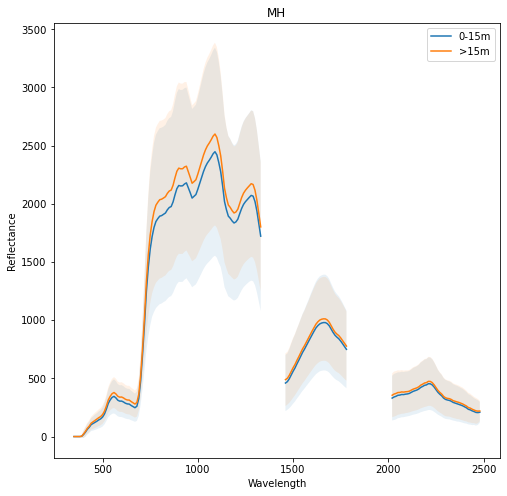

In [14]:
heights = [0,15]
plotSpectraSensitivity('MH', 'orig', 'tch', heights)

In [55]:

def plotSpectraSensitivity(site, folder, maskType, heightSens):

    pathMask = glob.glob('data/'+site+'/orig/*'+maskType+'.tif')
    mask = rasterio.open(pathMask[0])
    mask = mask.read()
    
    mask = mask[mask!=-9999]
    mask = mask[mask!=-0]
    mask2 = mask[mask<heightSens]
    
    return((mask2.shape[0]/mask.flatten().shape[0])*100)
        
site = ['YL', 'YH', 'ML', 'MH', 'OL', 'OH']
heights = 2

for i in site:
    result = plotSpectraSensitivity(i, 'orig', 'ndvi', 0.6) 
    print(i, result)

YL 6.0759060373967735
YH 0.7597895967270601
ML 0.16143033367345386
MH 4.077941297377292
OL 0.0
OH 0.0


In [7]:
def plotSpectraSensitivity(site, folder, maskType, ndviSens):
    plt.figure(figsize=(8,8))
    path = glob.glob('ohiaPlots/'+site+'/orig/*_refl.tif')
    refl = rasterio.open(path[0])
    refl =  refl.read()
    
    refl_arr = refl.astype('float')
    refl_arr[refl == -9999] = np.nan # or use np.nan
    mean_refl = np.nanmean(refl_arr, axis=(1,2))

    pathMask = glob.glob('ohiaPlots/'+site+'/'+folder+'/*'+maskType+'.tif')
    mask = rasterio.open(pathMask[0])
    mask = mask.read()
    
    for i in range(0, len(ndviSens)):

        maskThresh = (mask < ndviSens[i])
        mask_reshape = np.broadcast_to(maskThresh,(refl_arr.shape))
    
        refl_mask = np.ma.array(refl_arr, mask = mask_reshape)
    
        mean_refl = np.nanmean(refl_mask, axis=(1,2))
        std_refl = np.nanstd(refl_mask, axis=(1,2))
        
        s1= mean_refl.astype(np.float)+std_refl.astype(np.float)
        s2 = mean_refl.astype(np.float)-std_refl.astype(np.float)

        df = pd.DataFrame()
        df['reflectance']=mean_refl
        wav = np.arange(350, 2482, 10)
        df['wavelengths']= wav
        df['s1']=s1
        df['s2']=s2
        
        df.loc[((df.wavelengths >= 1340) & (df.wavelengths <= 1450)) | ((df.wavelengths >= 1790) & (df.wavelengths <= 2010))]=np.nan

        plt.plot(df.wavelengths, df.reflectance,label="> "+str(ndviSens[i]))
        plt.fill_between(wav, df.s1, df.s2, alpha=0.1)
    
    plt.legend
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')

    plt.title(site)
    plt.legend(loc='upper right')
    plt.rcParams.update({'font.size': 16})
    plt.show

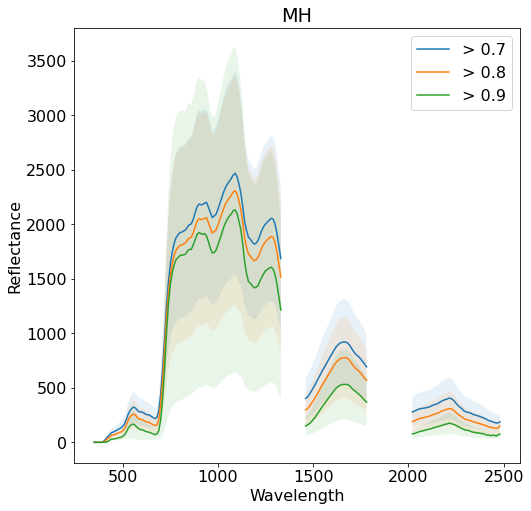

In [8]:
ndvis = [0.7,0.8, 0.9]
plotSpectraSensitivity('MH', 'ndvi', 'ndvi', ndvis)

# Comparing across Sites


In [89]:
# # # Import filtered data, remove water bands, and normalize
# YL_nn = importData(rasterio.open('data/orig/YL_filtered.tif'), norm = False)
# YH_nn = importData(rasterio.open('data/orig/YH_filtered.tif'), norm = False)
# ML_nn = importData(rasterio.open('data/orig/ML_filtered.tif'), norm = False)
# MH_nn = importData(rasterio.open('data/orig/MH_filtered.tif'), norm = False)
# OL_nn = importData(rasterio.open('data/orig/OL_filtered.tif'), norm = False)
# OH_nn = importData(rasterio.open('data/orig/OH_filtered.tif'), norm = False)

# Import filtered data, remove water bands, and normalize
YL = importData(rasterio.open('data/orig/YL_filtered.tif'))
YH = importData(rasterio.open('data/orig/YH_filtered.tif'))
ML = importData(rasterio.open('data/orig/ML_filtered.tif'))
MH = importData(rasterio.open('data/orig/MH_filtered.tif'))
OL = importData(rasterio.open('data/orig/OL_filtered.tif'))
OH = importData(rasterio.open('data/orig/OH_filtered.tif'))

YL_len = YL.shape[1]
YH_len = YH.shape[1]
ML_len = ML.shape[1]
MH_len = MH.shape[1]
OL_len = OL.shape[1]
OH_len = OH.shape[1]

In [96]:
np.save('data/refl/OH_refl.npy' ,OH)

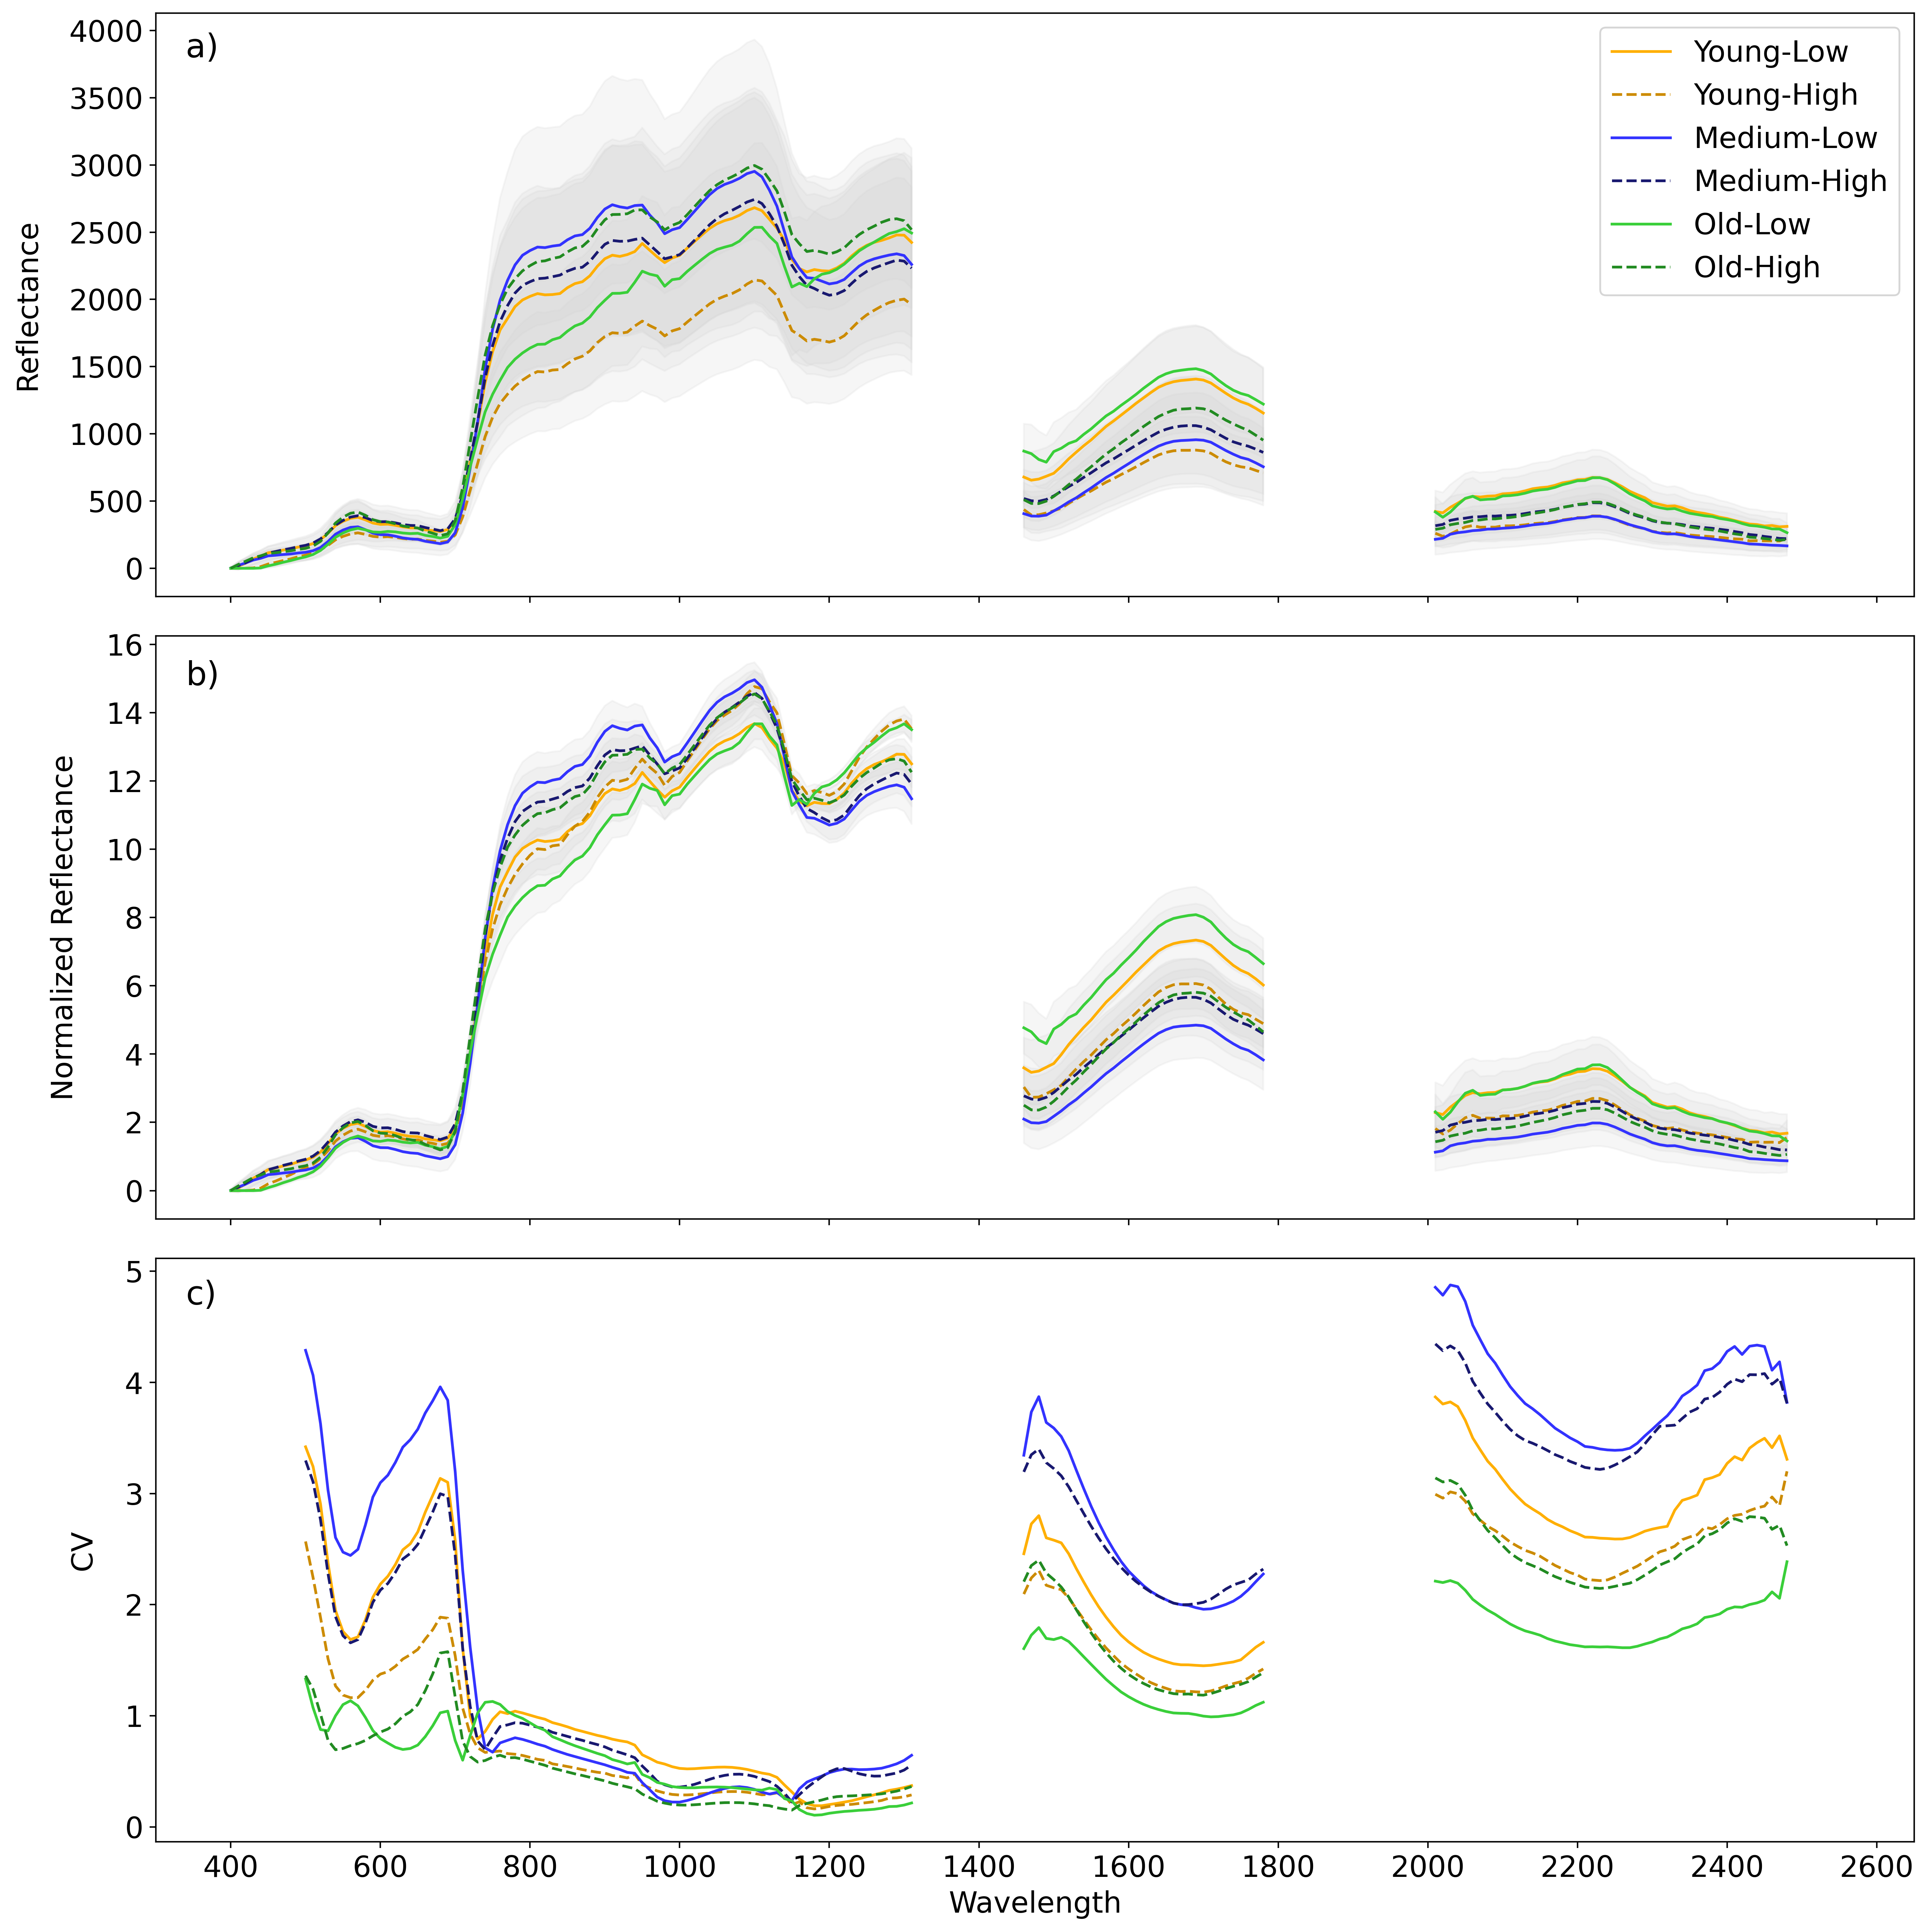

In [12]:
fig, ax = plt.subplots(3, sharex = True, figsize = (15,15), dpi = 400)

std_len = min(YL_len,
             YH_len,
             ML_len,
             MH_len,
             OL_len,
             OH_len)

siteNames = [YL_nn, YH_nn, ML_nn, MH_nn, OL_nn, OH_nn]


for i, j in enumerate(siteNames):
    meandat, sd1dat, sd2dat = getMeanSD(j)
    s = specFill(meandat)
    if i==1:
        maxRefl = np.nanmax((df.reflectance, s), axis = 0)
    elif i>1:
        maxRefl = np.nanmax((maxRefl, s), axis = 0)
    df = pd.DataFrame()
    df['reflectance']=s
    wav = np.arange(400, 2490, 10)
    df['wavelengths']= wav
    df['s1']=specFill(sd1dat)
    df['s2']=specFill(sd2dat)

    ax[0].plot(df.wavelengths, df.reflectance,label=site_full[i], c = cramp[i], linestyle = line[i])
    ax[0].fill_between(wav, df.s1, df.s2, color = 'lightgray', alpha = 0.2)

ax[0].legend(loc = 'upper right')


siteNames = [YL, YH, ML, MH, OL, OH]

for i, j in enumerate(siteNames):
    meandat, sd1dat, sd2dat = getMeanSD(j)
    s = specFill(meandat)
    if i==1:
        maxRefl = np.nanmax((df.reflectance, s), axis = 0)
    elif i>1:
        maxRefl = np.nanmax((maxRefl, s), axis = 0)
    df = pd.DataFrame()
    df['reflectance']=s
    wav = np.arange(400, 2490, 10)
    df['wavelengths']= wav
    df['s1']=specFill(sd1dat)
    df['s2']=specFill(sd2dat)

    ax[1].plot(df.wavelengths, df.reflectance*100,label=site[i], c = cramp[i], linestyle = line[i])
    ax[1].fill_between(wav, df.s1*100, df.s2*100, color = 'lightgray', alpha = 0.2)

    
siteNames = [YL[:,sorted(random.sample((range(YL.shape[1])), std_len))],
             YH[:,sorted(random.sample((range(YH.shape[1])), std_len))],
             ML[:,sorted(random.sample((range(ML.shape[1])), std_len))],
             MH[:,sorted(random.sample((range(MH.shape[1])), std_len))],
             OL[:,sorted(random.sample((range(OL.shape[1])), std_len))],
             OH[:,sorted(random.sample((range(OH.shape[1])), std_len))]]

df_mean = pd.DataFrame()
df_sd= pd.DataFrame()

wav = np.arange(400, 2490, 10)
for i, j in enumerate(siteNames):
    meandat, sd1dat, sd2dat = getMeanSD(j)
    sd = sd1dat-meandat
    df_mean=specFill(meandat)
    df_sd=specFill(sd)
    cv = df_sd/df_mean
    cv[0:10]=np.nan
    
    ax[2].plot(wav, cv*10, label=site[i], c = cramp[i], linestyle = line[i])


plt.legend
plt.xlabel('Wavelength')
ax[0].set_ylabel('Reflectance', labelpad=15)
ax[1].set_ylabel('Normalized Reflectance', labelpad=15)
ax[2].set_ylabel('CV', labelpad=15)

ax[0].text(340,3800, 'a)', fontsize = 18)
ax[1].text(340,14.8, 'b)', fontsize = 18)
ax[2].text(340,4.7, 'c)', fontsize = 18)

ax[0].set_xlim([300, 2650])
ax[1].set_xlim([300, 2650])
ax[2].set_xlim([300, 2650])

for a in ax.flat:
    a.label_outer()

ax[2].set_xticks(np.arange(400, 2800, 200))
plt.tight_layout(w_pad = 0.3)

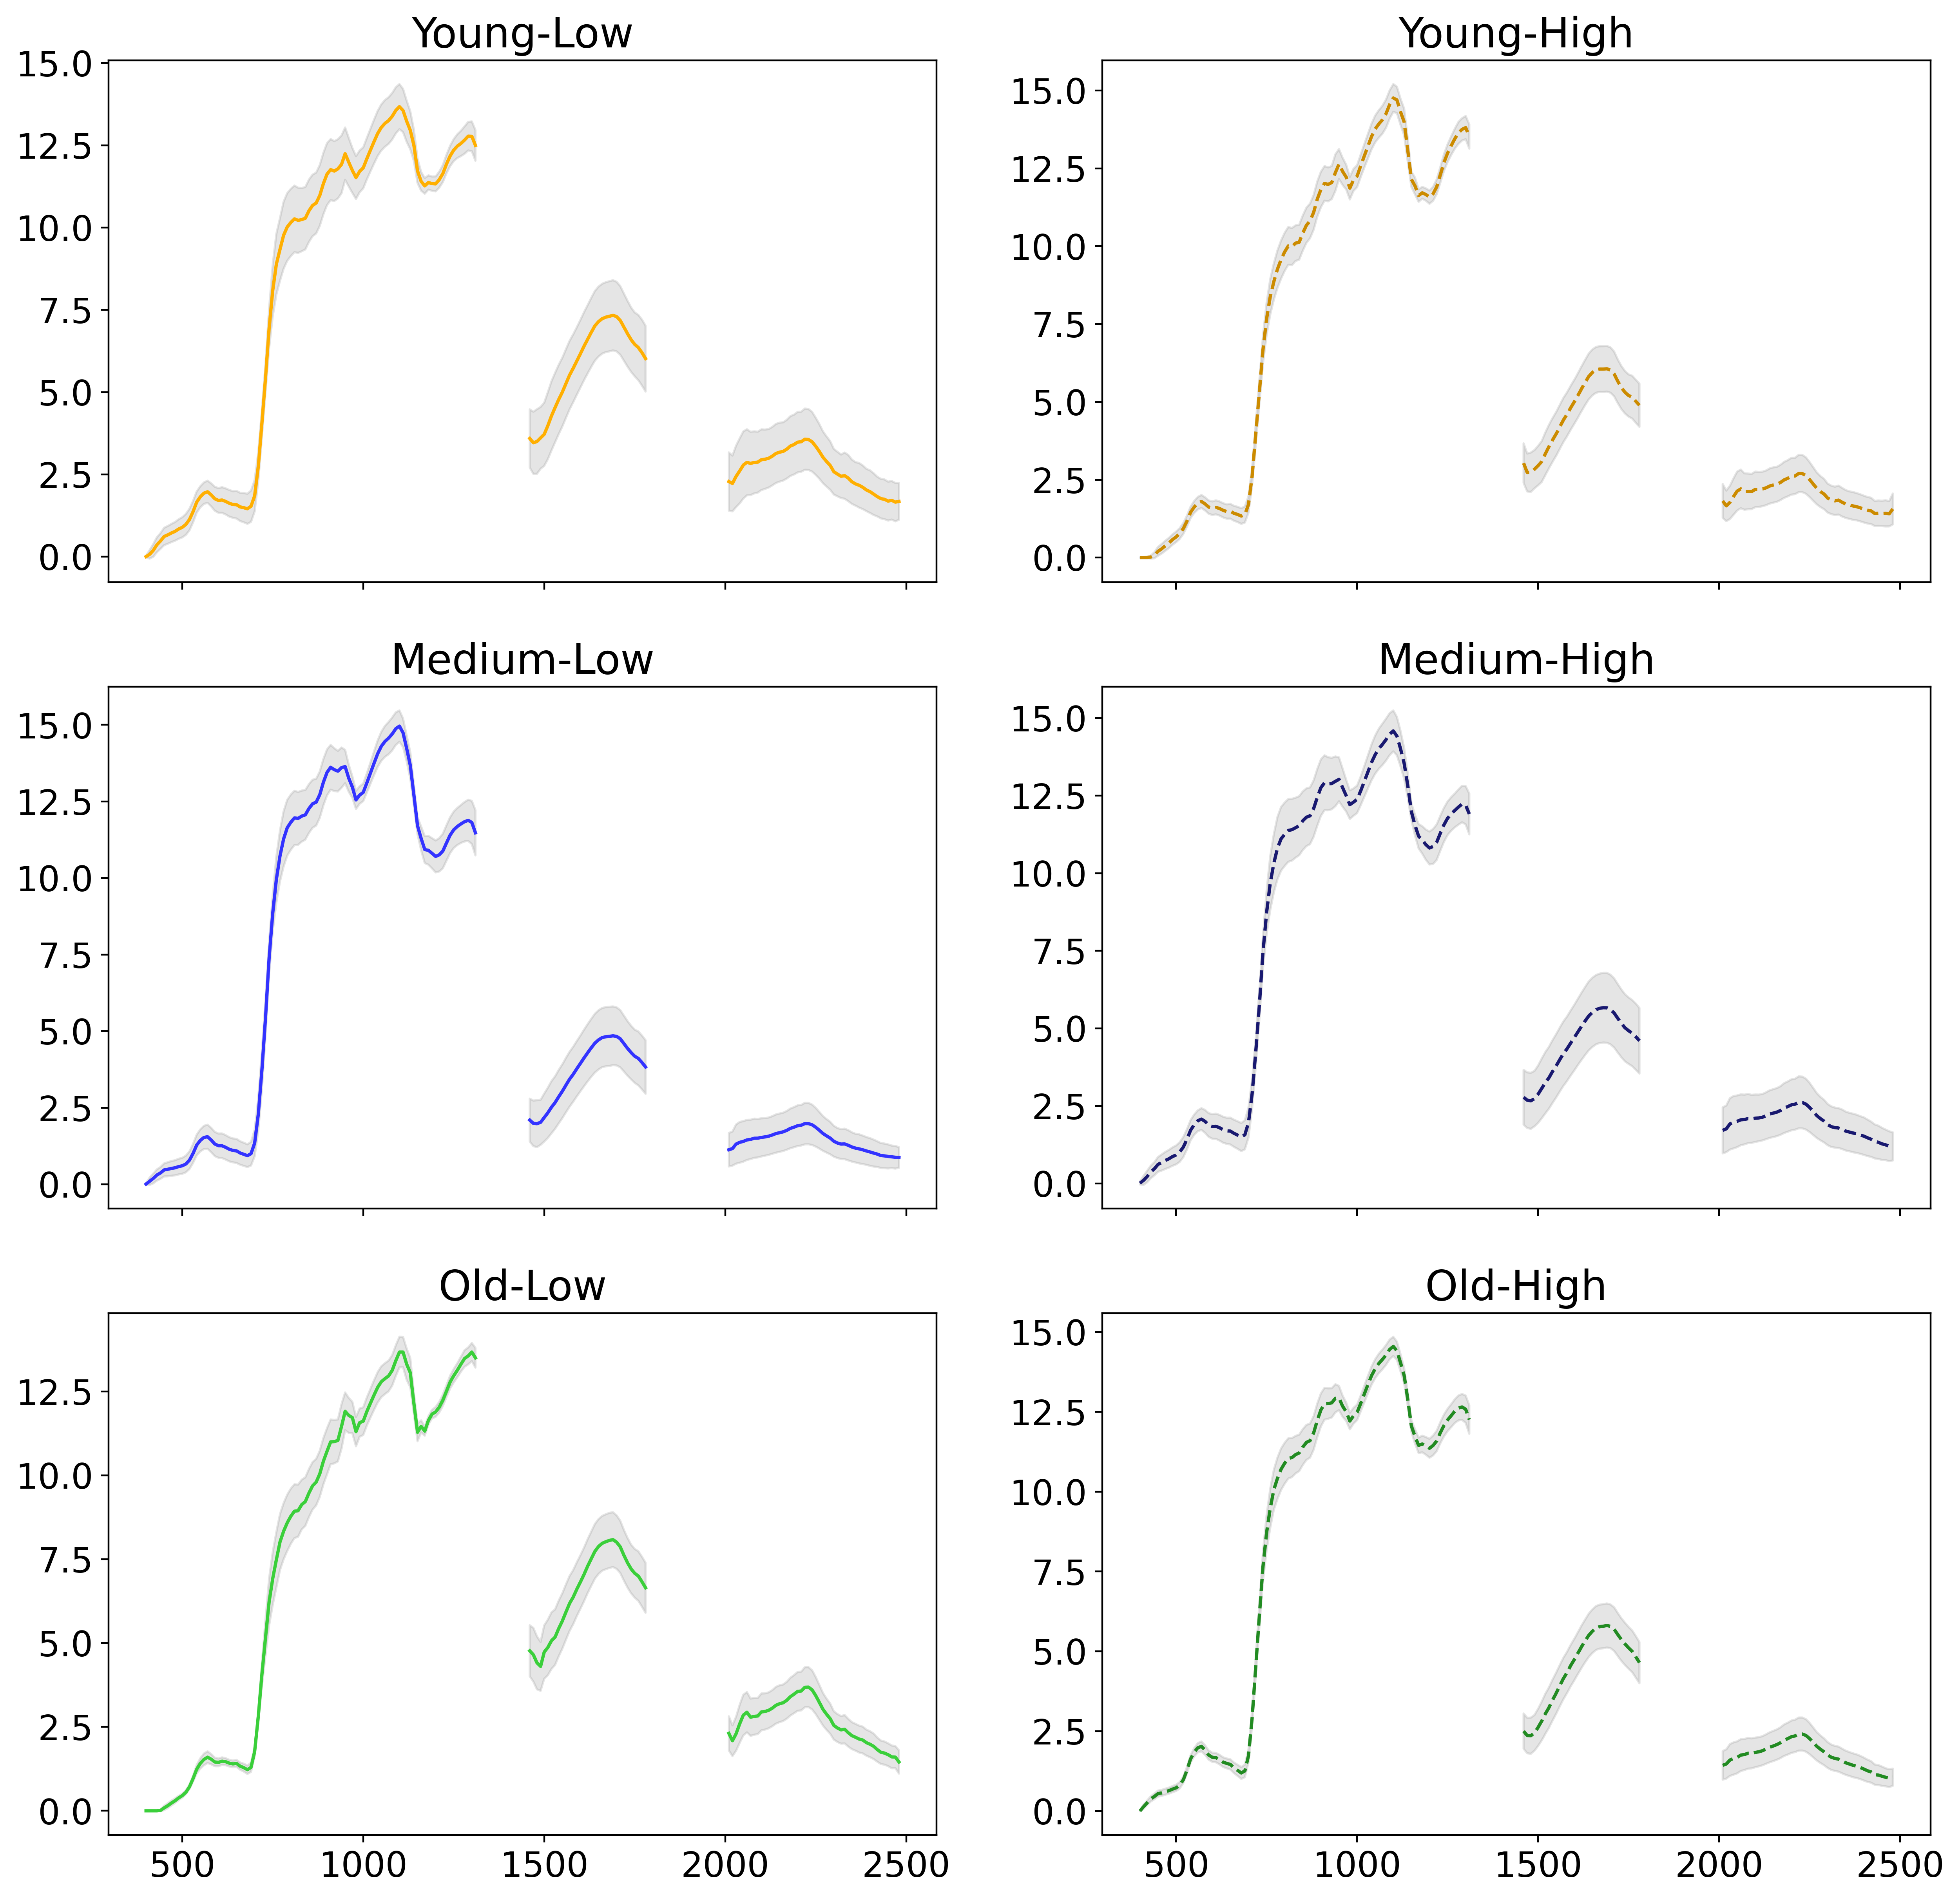

In [12]:
fig, ax = plt.subplots(3,2, sharex = True, figsize = (15,15), dpi = 400)
site_full = ['Young-Low', 'Young-High', 'Medium-Low', 'Medium-High', 'Old-Low', 'Old-High']

siteNames = [YL, YH, ML, MH, OL, OH]
t = 0
for i, j in enumerate(siteNames):
    meandat, sd1dat, sd2dat = getMeanSD(j)
    s = specFill(meandat)
    if i==1:
        maxRefl = np.nanmax((df.reflectance, s), axis = 0)
    elif i>1:
        maxRefl = np.nanmax((maxRefl, s), axis = 0)
    df = pd.DataFrame()
    df['reflectance']=s
    wav = np.arange(400, 2490, 10)
    df['wavelengths']= wav
    df['s1']=specFill(sd1dat)
    df['s2']=specFill(sd2dat)
    if (i % 2 == 0):
        ax[t,0].plot(df.wavelengths, df.reflectance*100,label=site[i], c = cramp[i], linestyle = line[i])
        ax[t,0].fill_between(wav, df.s1*100, df.s2*100, color = 'gray', alpha = 0.2)
        ax[t,0].set_title(site_full[i])
        
    else:
        ax[t,1].plot(df.wavelengths, df.reflectance*100,label=site[i], c = cramp[i], linestyle = line[i])
        ax[t,1].fill_between(wav, df.s1*100, df.s2*100, color = 'gray', alpha = 0.2)
        ax[t,1].set_title(site_full[i])
        t = t+1
        
    

# PCA


In [8]:
def pca(dat, sameSite = 'yes'):
    C = np.cov(dat)
    D,V = np.linalg.eig(C)
    if sameSite == 'yes':
        reflPCA = np.dot(V.T, dat)
    else:
        reflPCA = np.dot(V.T, sameSite)
    return reflPCA, V

pca_yl = pca(YL)
pca_yh = pca(YL, YH)

In [12]:
pca_yh

(array([[-0.08744717, -0.07949737, -0.11766799, ..., -0.05395974,
         -0.10752262, -0.16771597],
        [-0.17580798, -0.17780982, -0.17893071, ..., -0.16481763,
         -0.16225678, -0.17180549],
        [-0.06001929, -0.05252869, -0.06025132, ..., -0.05471023,
         -0.06263674, -0.07592424],
        ...,
        [-0.00172486, -0.00194101, -0.00191352, ..., -0.00129568,
         -0.00223873, -0.00075754],
        [ 0.00049276,  0.00100082,  0.00067216, ...,  0.00069855,
          0.00085031,  0.00089222],
        [ 0.000452  ,  0.00041071,  0.00090083, ...,  0.00072741,
          0.00076017,  0.00019753]]),
 array([[ 4.85384280e-04,  4.08703900e-03,  7.87177843e-05, ...,
          2.04793508e-03,  3.84307652e-03, -1.78925349e-03],
        [ 7.15006626e-03,  4.03000884e-02, -5.56372634e-03, ...,
          1.01669657e-02, -1.34569058e-02, -6.84535122e-02],
        [ 1.25141646e-02,  6.21227329e-02, -1.63289587e-02, ...,
         -2.05233392e-02,  2.60061125e-02,  1.57748819e-

In [13]:
all_data = np.hstack((YL, 
                      YH,
                     ML,
                     MH,
                     OL,
                     OH))

reflPCA, V = pca(all_data)

In [14]:
C = np.cov(all_data)
D,V = np.linalg.eig(C)

explained_variances = []
for i in range(len(D)):
    explained_variances.append(D[i] / np.sum(D))
 
pd.DataFrame([np.arange(1,176),explained_variances]).T.to_csv('images/PC_loadings.csv')

In [42]:
np.sum(explained_variances[0])

0.019466027414755366

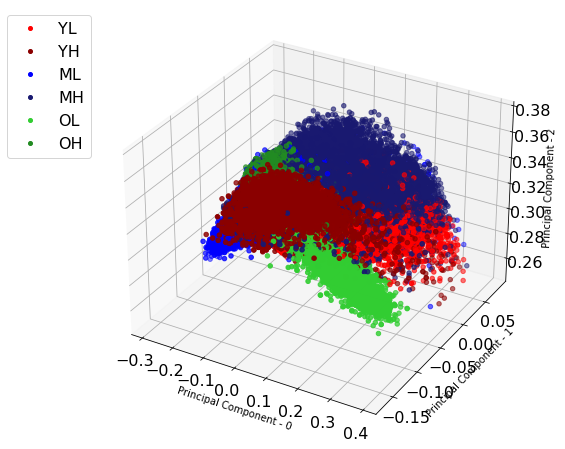

In [12]:
col = np.concatenate(((np.repeat('red',YL_len)), 
                     (np.repeat('darkred',YH_len)),
                    (np.repeat('blue',ML_len)),
                    (np.repeat('midnightblue',MH_len)),
                    (np.repeat('limegreen',OL_len)),
                    (np.repeat('forestgreen',OH_len))))

plotPC(reflPCA, [0,1,2], col)

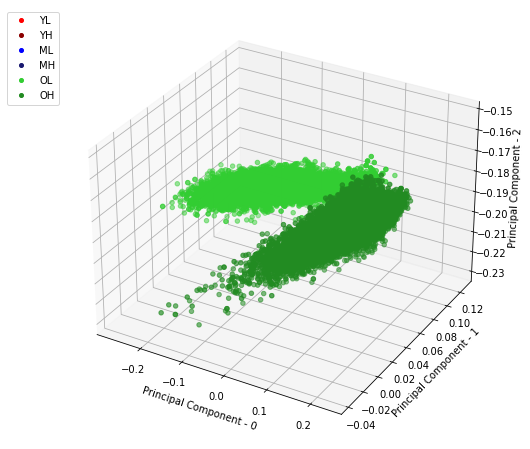

In [13]:
%matplotlib inline

std_len = min(OL.shape[1],
             OH.shape[1])

all_dataElev = np.hstack((OL[:,sorted(random.sample((range(OL.shape[1])), std_len))],
                       OH[:,sorted(random.sample((range(OH.shape[1])), std_len))]))

colElev = np.concatenate(((np.repeat('limegreen',std_len)),
                     (np.repeat('forestgreen',std_len))))

plotPC(pca(all_dataElev)[0], [0,1,2], colElev)

# Map PCs Across Space

In [15]:
# # Creates PCA maps (and optionally writes them)

YL_sq = importData(rasterio.open('ohiaPlots/YL/orig/YL_filtered_sq.tif'))
YH_sq = importData(rasterio.open('ohiaPlots/YH/orig/YH_filtered_sq.tif'))
ML_sq = importData(rasterio.open('ohiaPlots/ML/orig/ML_filtered_sq.tif'))
MH_sq = importData(rasterio.open('ohiaPlots/MH/orig/MH_filtered_sq.tif'))
OL_sq = importData(rasterio.open('ohiaPlots/OL/orig/OL_filtered_sq.tif'))
OH_sq = importData(rasterio.open('ohiaPlots/OH/orig/OH_filtered_sq.tif'))

sites = [YL_sq,
            YH_sq,
            ML_sq,
            MH_sq,
            OL_sq,
            OH_sq]

addTo = [YL_sq.shape[1], YH_sq.shape[1], ML_sq.shape[1], MH_sq.shape[1], OL_sq.shape[1], OH_sq.shape[1]]
start = 0
end = addTo[0]

for i, j in enumerate(sites):

    localPCA, V = pca(j) 
    
    s = site[i]
    siteIn = rasterio.open('ohiaPlots/'+s+'/orig/'+s+'_filtered_sq.tif')

    bands = np.arange(5,214)
    bands = np.delete(bands, np.where((bands>=144) & (bands<166)))
    bands = np.delete(bands, np.where((bands>=99) & (bands<110)))

    # Reshape data (flatten to 2d) and remove no data
    for b in bands:
        tmpdat = siteIn.read(indexes=[b])
        if (b == 5):
            site_part = tmpdat
        else:
            site_part = np.append(site_part, tmpdat, axis =0)

    mask = site_part.flatten()!=-9999

    new_array = np.empty(site_part.flatten().shape)
    new_array[:]=np.nan

    new_array[mask]= localPCA.flatten()
    new_array = new_array.reshape(site_part.shape)


    profile = siteIn.meta
    profile.update(count = 176, dtype = 'float64')

    with rasterio.open('ohiaPlots/'+s+'/pc/'+s+'_localPC_stdArea_filt.tif', 'w', **profile) as dst:
        dst.write(new_array)

RasterioIOError: ohiaPlots/YL/orig/YL_filtered_sq.tif: No such file or directory

In [16]:
# Plots PCA maps by reading in existing PCA map files (see above)
lens = np.concatenate(((np.repeat('YL',YL_len)), 
                     (np.repeat('YH',YH_len)),
                    (np.repeat('ML',ML_len)),
                    (np.repeat('MH',MH_len)),
                    (np.repeat('OL',OL_len)),
                    (np.repeat('OH',OH_len))))


%matplotlib inline

def plotPC_maps(PC, PCend="bubbly"):
    site_title = ["YL", "YH", "ML", "MH", "OL", "OH"]
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize = (20,20))
    ax = ax.flat
    PC_means = []
    PC_sd = []
    for i, j in enumerate(site_title):
        new_array = rasterio.open('ohiaPlots/'+j+'/pc/'+j+'_pc_orig.tif').read()
        ax[i].axis('off')
        ax[i].imshow(new_array[PC], vmin = reflPCA[PC,:].mean()-(reflPCA[PC,:].std()), vmax = reflPCA[PC,:].mean()+(reflPCA[PC,:].std()))
        ax[i].imshow(new_array[PC], vmin = reflPCA[PC,:].min(), vmax = reflPCA[PC,:].max())
        ax[i].imshow(new_array[PC])
        ax[i].set_title(site_title[i]+' Mean: ' +str(np.nanmean(new_array[PC])), fontsize = 30)

        print('Scalebar | min: ' + str(reflPCA[PC,:].min()) + ' max: '+ str(reflPCA[PC,:].max()))
    print('Min: '+str(reflPCA[PC,:].min())+' | Max: '+str(reflPCA[PC,:].max()))
    

    # Plot PC Var within site
    dfBox = pd.DataFrame()
    dfBox['refl']=reflPCA[PC,:]
    dfBox['site']=lens

    bp = dfBox.boxplot(column = ['refl'], by = ['site'])
    plt.xlab = 'Site'
    
    fig = np.asarray(bp).reshape(-1)[0].get_figure()
    fig.suptitle('')


Scalebar | min: -0.2863885518768387 max: 0.3895735317013202
Scalebar | min: -0.2863885518768387 max: 0.3895735317013202
Scalebar | min: -0.2863885518768387 max: 0.3895735317013202
Scalebar | min: -0.2863885518768387 max: 0.3895735317013202
Scalebar | min: -0.2863885518768387 max: 0.3895735317013202
Scalebar | min: -0.2863885518768387 max: 0.3895735317013202
Min: -0.2863885518768387 | Max: 0.3895735317013202


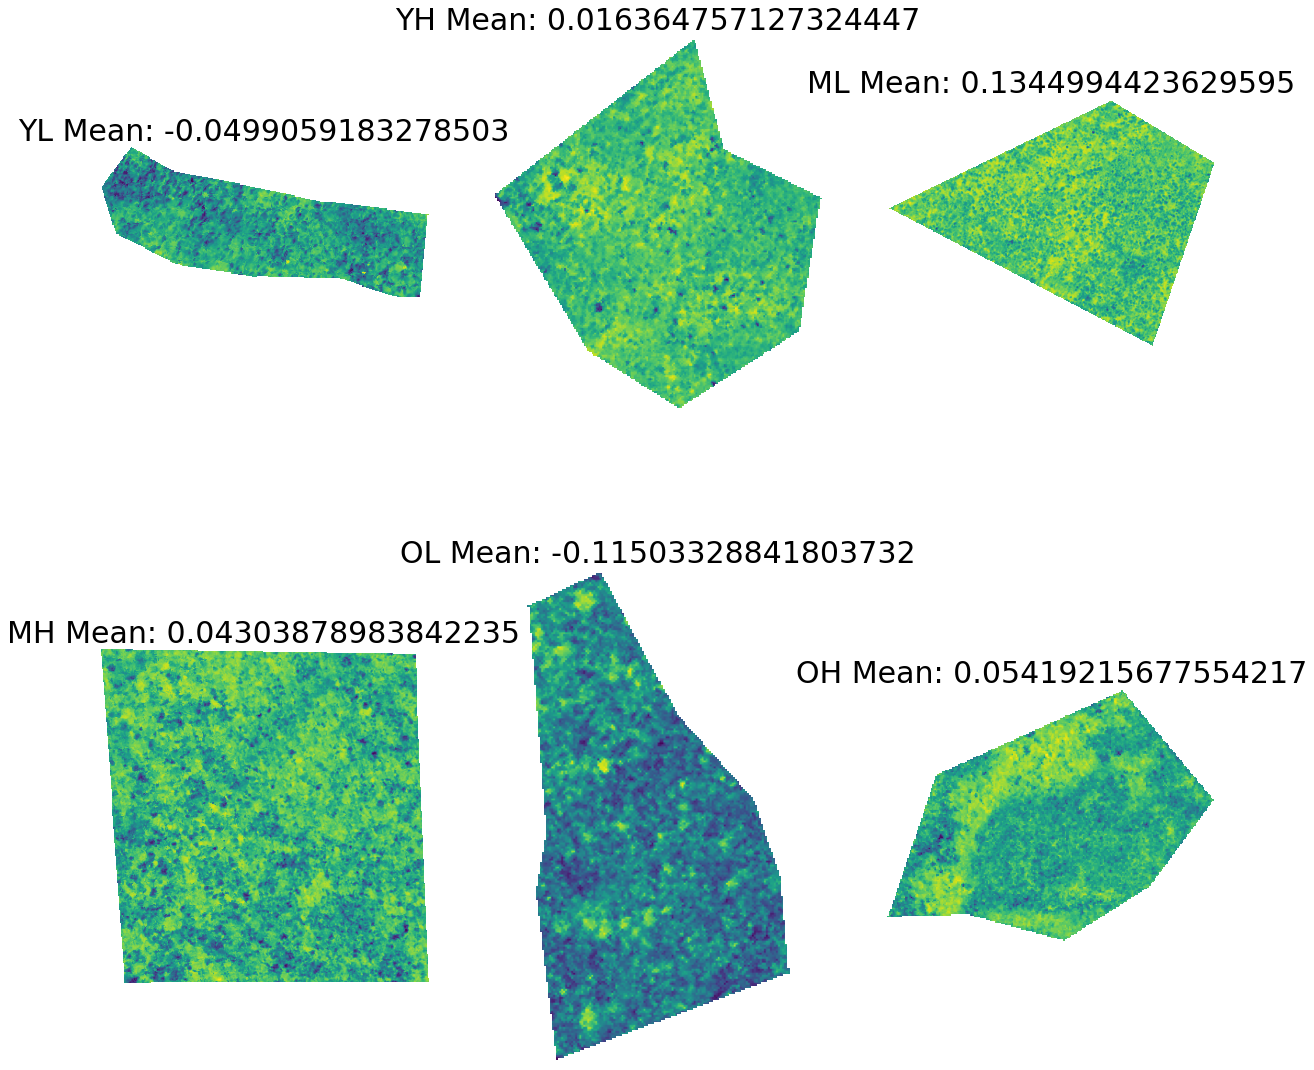

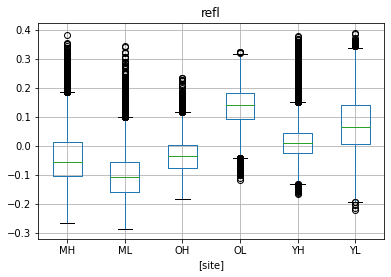

In [16]:
plotPC_maps(0)

# Dimensionality

In [25]:
# For all PCs
signal = []
noise = []    


    
    
for s in site:
    signal = []
    noise = []
    rast = rasterio.open('data/''/pc/'+s+'_PC_stdArea.tif').read()
    for b in range(40):
        n = rast[b,:,:]
        new_array = np.empty(n.shape)
        new_array[:]=np.nan
        for i in range(n.shape[0]):
            for j in range(n.shape[1]):
                if (i == 0 )| (i == n.shape[0]-1) | (j == 0) | (j == n.shape[1]-1) | (np.isnan(n[i,j])):
                    new_array[i,j]=np.nan
                else:
                    smoothed = np.nanmean((n[i,j], 
                                   n[i-1,j], 
                                   n[i+1,j],
                                  n[i,j+1], 
                                   n[i-1,j+1], 
                                   n[i+1,j+1],
                                  n[i,j-1], 
                                   n[i-1,j-1], 
                                   n[i+1,j-1]))
                    new_array[i,j]=smoothed

        sig = new_array.flatten()
        noi = (new_array-n).flatten()

        signal = np.append(signal, np.nanstd(sig))
        noise = np.append(noise, np.nanstd(noi))

    print("Number of Dimenstions: "+s+" "+str(np.where(noise>=signal)[0]))

Number of Dimenstions: YL [11 12 18 20 21 22 23 24 25 27 28 29 30 31 32 33 34 35 36 37 38 39]
Number of Dimenstions: YH [ 7  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39]
Number of Dimenstions: ML [12 16 19 20 27 29 30 31 32 33 34 35 36 38 39]
Number of Dimenstions: MH [12 16 19 24 27 28 29 30 31 32 33 34 35 36 37 38 39]
Number of Dimenstions: OL [ 4  9 10 11 12 14 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39]
Number of Dimenstions: OH [ 3  9 11 12 16 18 19 20 21 22 23 24 25 27 28 29 30 31 32 33 34 35 36 38
 39]


In [97]:
from scipy.ndimage import gaussian_filter

# For all PCs
signal = []
noise = []    


    
    
for s in site:
    signal = []
    noise = []
    rast = rasterio.open('data/pc/'+s+'_localPC_stdArea_filt.tif').read()
    for b in range(40):
        n = rast[b,:,:]
        new_array = np.empty(n.shape)
        new_array[:]=np.nan
        for i in range(n.shape[0]):
            for j in range(n.shape[1]):
                if (i == 0 )| (i == n.shape[0]-1) |(i == n.shape[0]-2) | (j == 0) | (j == n.shape[1]-1) | (j == n.shape[1]-2) | (np.isnan(n[i,j])):
                    new_array[i,j]=np.nan
                else:
                    smoothed = np.nanmean((n[i,j], 
                                   n[i-1,j], 
                                   n[i+1,j],
                                  n[i,j+1], 
                                   n[i-1,j+1], 
                                   n[i+1,j+1],
                                  n[i,j-1], 
                                   n[i-1,j-1], 
                                   n[i+1,j-1],
                                    n[i-2,j], 
                                   n[i+2,j],
                                  n[i,j+2], 
                                   n[i-2,j+2], 
                                   n[i+2,j+2],
                                  n[i,j-2], 
                                   n[i-2,j-2], 
                                   n[i+2,j-2], 
                                   n[i-1,j-2], 
                                   n[i+1,j-2], 
                                   n[i-2,j-1], 
                                   n[i+2,j-1],
                                    n[i-1,j+2], 
                                   n[i+1,j+2],
                                          n[i-2,j+1], 
                                   n[i+2,j+1]))
                    new_array[i,j]=smoothed

        sig = new_array.flatten()
        noi = (new_array-n).flatten()

        signal = np.append(signal, np.nanstd(sig))
        noise = np.append(noise, np.nanstd(noi))

    print("Number of Dimenstions: "+s+" "+str(np.where(noise>=signal)[0]))

Number of Dimenstions: YL [ 1  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39]
Number of Dimenstions: YH [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Number of Dimenstions: ML [ 2  4  5  7 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39]
Number of Dimenstions: MH [ 3  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39]
Number of Dimenstions: OL [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Number of Dimenstions: OH [ 2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [49]:
#9x9
# global [7,0,14,16,3,6]
# local [6,0,10,6,0,5]


# For all PCs
signal = []
noise = []
    
# All Sites

sig = []
noi = []



for k, s in enumerate(site):
    rast = rasterio.open('data/pc/'+s+'_PC_stdArea.tif').read()
    print(rast.shape)
#     rast_sub = rast[:, :31, :47]
    rast_sub = rast
    if k == 0:
        rast_top = rast_sub
    elif (k == 3) | (k ==5):
        rast_top = np.append(rast_top, rast_sub, axis = 1)
        
    elif k == 1:
        rast_bot = rast_sub
        print(rast_bot.shape, 'loop')
    elif (k == 2) | (k ==4):
        rast_bot = np.append(rast_bot, rast_sub, axis = 1)
        print(rast_bot.shape, 'loop')

print(rast_bot.shape)
print(rast_top.shape)

rast_comb = np.append(rast_top, rast_bot, axis = 2)
print(rast_comb.shape)


for b in range(40):

    n = rast_comb[b,:,:]
    new_array = np.empty(n.shape)
    new_array[:]=np.nan

    for i in range(n.shape[0]):
        for j in range(n.shape[1]):
            if (i == 0 )| (i == n.shape[0]-1) | (j == 0) | (j == n.shape[1]-1) | (np.isnan(n[i,j])):
                new_array[i,j]=np.nan
            else:
                s = np.nanmean((n[i,j], 
                               n[i-1,j], 
                               n[i+1,j],
                              n[i,j+1], 
                               n[i-1,j+1], 
                               n[i+1,j+1],
                              n[i,j-1], 
                               n[i-1,j-1], 
                               n[i+1,j-1]))
                new_array[i,j]=s

    sig = np.append(sig, np.nanstd(new_array.flatten()))
    noi = np.append(noi, np.nanstd((new_array-n).flatten()))

print("all_sites")
print(np.where(noi>=sig))



(176, 93, 93)
(176, 93, 93)
(176, 93, 93) loop
(176, 93, 93)
(176, 186, 93) loop
(176, 93, 93)
(176, 93, 93)
(176, 279, 93) loop
(176, 93, 93)
(176, 279, 93)
(176, 279, 93)
(176, 279, 186)
all_sites
(array([11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
       30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),)


In [46]:
94*2

188

In [37]:
93/2

46.5

In [37]:

ind5 =  np.array([6,0,10,6,0,5])
same5 = np.array([7,0,14,16,3,6])


# First run of 3
indivPc = np.array([8,4,17,17,10,9])
samePc = np.array([20,9,29,27,9,18])

In [38]:
ind5/indivPc

array([0.75      , 0.        , 0.58823529, 0.35294118, 0.        ,
       0.55555556])

In [39]:
same5/samePc

array([0.35      , 0.        , 0.48275862, 0.59259259, 0.33333333,
       0.33333333])

Text(0, 0.5, 'Dimensions')

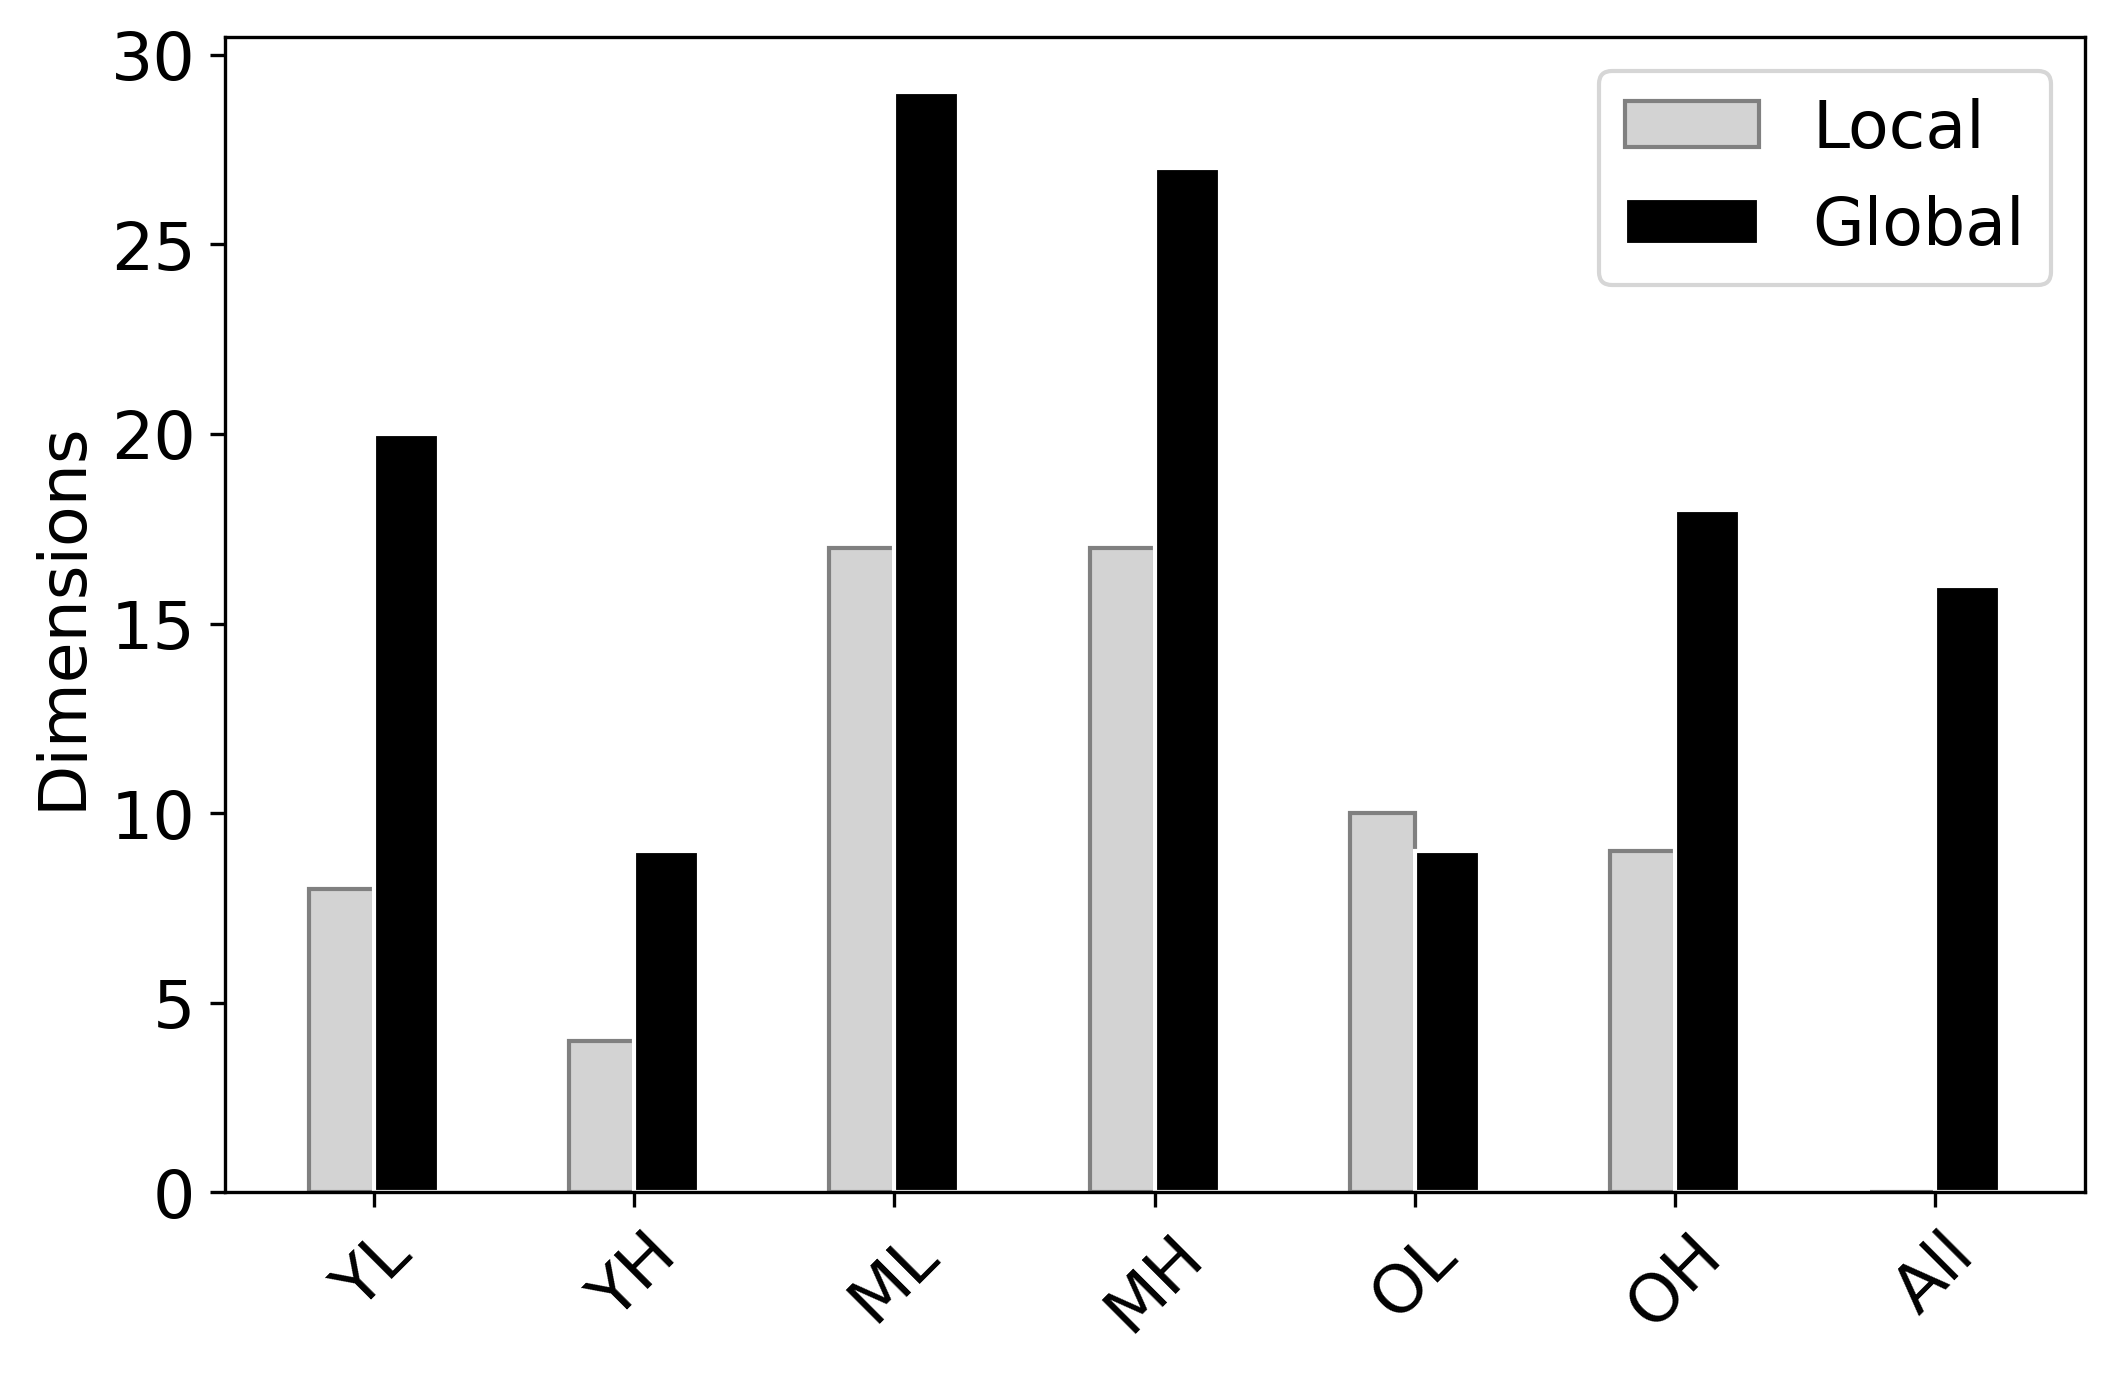

In [48]:
##9x9

# local [6,0,10,6,0,5]
#global [7,0,14,16,3,6]


# First run of 3
indivPc = np.array([8,4,17,17,10,9, 0])
samePc = np.array([20,9,29,27,9,18,16])

siteNamesString = ["YL", "YH", "ML", "MH", "OL", "OH", "All"]
site_full = ['Young-Low', 'Young-High', 'Medium-Low', 'Medium-High', 'Old-Low', 'Old-High', 'All Sites']

pc_dims = pd.DataFrame()
pc_dims['Site']=siteNamesString
pc_dims['DimsIndivBase'] = indivPc
pc_dims['DimsSameBase'] = samePc


fig = plt.figure(figsize=(8,5), dpi = 300)
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(pc_dims.Site))
r2 = [x + barWidth for x in r1]

# Create bars
plt.bar(r1, pc_dims.DimsIndivBase,width=barWidth, edgecolor='gray', label='Local', color = 'lightgray')
plt.bar(r2, pc_dims.DimsSameBase,width=barWidth, edgecolor='white', label='Global', color = 'black')
plt.legend()
# Create names on the x-axis
plt.xticks((r1+r2)/2, pc_dims.Site, rotation = 45)
# plt.legend()
plt.ylabel('Dimensions')

# SVM

In [18]:
YL.shape


(176, 12997)

In [25]:
# minPix = min((YL_len, 
#                       YH_len,
#                      ML_len,
#                      MH_len,
#                      OL_len,
#                      OH_len))

sub = minPix
partition = int(sub*0.33)

In [106]:
sub = minPix
partition = int(sub*0.33)

random.seed(10)
ran_pixels_test = sorted(random.sample((range(sub)), partition))


start = 0
end = minPix


for n in range(6):
    sub_dat = all_chem[:, start:end]
    
    sub_train = sub_dat[:, partition:]
    sub_test = sub_dat[:, :partition]
    
    if n == 0:
        x_train = sub_train
        x_test = sub_test
    else:
        x_train = np.hstack((x_train, sub_train))
        x_test = np.hstack((x_test, sub_test))
        
    start = start + minPix
    end = end + minPix
    
test_partition = sub-partition
y_train = np.concatenate((np.zeros(test_partition),
                            (np.ones(test_partition)),
                            (np.ones(test_partition)*2),
                            (np.ones(test_partition)*3),
                            (np.ones(test_partition)*4),
                            (np.ones(test_partition)*5)))

y_test = np.concatenate((np.zeros(partition),
                            (np.ones(partition)),
                            (np.ones(partition)*2),
                            (np.ones(partition)*3),
                            (np.ones(partition)*4),
                            (np.ones(partition)*5)))

rbf_svc = svm.SVC(kernel='rbf', random_state = 20)
rbf_svc.fit(x_train.T, y_train)

y_pred = rbf_svc.predict(x_test.T)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.77926466612598


In [107]:
metrics.precision_score(y_test, y_pred, average = 'weighted')

0.7934536512275564

In [108]:
confusion_matrix(y_test, y_pred)

array([[1614,   98,  117,   71,   91,  475],
       [ 105, 2037,   18,  100,    0,  206],
       [ 120,    8, 1946,  172,    5,  215],
       [ 165,   81,  187, 1559,    8,  466],
       [ 134,    0,   18,    0, 2274,   40],
       [  66,   41,  132,  127,    0, 2100]])

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [10000., 100., 1., 1e-2, 1e-4], "C": [1e-3, 1e-1, 10, 1000]},
]

scores = ["precision", "recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(x_train.T, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test.T)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision



In [30]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9587431693989071


In [31]:
metrics.precision_score(y_test, y_pred, average = 'weighted')

0.9590785653069606

In [32]:
pd.DataFrame(np.round((confusion_matrix(y_test, y_pred)/partition)*100, 1)).to_csv('confusion_matrix_chems.csv')

In [33]:
np.round((confusion_matrix(y_test, y_pred)/partition)*100, 1)

array([[93.8,  0.1,  0.7,  4.7,  0.6,  0.2],
       [ 0.3, 98.6,  0.1,  0.6,  0.4,  0. ],
       [ 1.1,  0. , 97. ,  1. ,  0. ,  0.9],
       [ 3.6,  0.1,  3. , 91.8,  0. ,  1.5],
       [ 0. ,  0.1,  0. ,  0. , 99.8,  0. ],
       [ 0.1,  0. ,  4.3,  1.4,  0. , 94.3]])

In [80]:
YL_sub = YL[:,0:minPix]
YH_sub = YH[:,0:minPix]
ML_sub = ML[:,0:minPix]
MH_sub = MH[:,0:minPix]
OL_sub = OL[:,0:minPix]
OH_sub = OH[:,0:minPix]

all_data = np.hstack((YL_sub, 
                      YH_sub,
                     ML_sub,
                     MH_sub,
                     OL_sub,
                     OH_sub))

reflPCA, V = pca(all_data)

In [81]:
minPix

12997

In [82]:
sub = minPix
partition = int(sub*0.33)

random.seed(10)
ran_pixels_test = sorted(random.sample((range(sub)), partition))


start = 0
end = minPix


for n in range(6):
    sub_dat = reflPCA[:16, start:end]
    sub_train = sub_dat[:, partition:]
    sub_test = sub_dat[:, :partition]
    print(sub_train.shape, sub_test.shape)
    
    if n == 0:
        x_train = sub_train
        x_test = sub_test
    else:
        x_train = np.hstack((x_train, sub_train))
        x_test = np.hstack((x_test, sub_test))
        
    start = start + minPix
    end = end + minPix

(16, 8708) (16, 4289)
(16, 8708) (16, 4289)
(16, 8708) (16, 4289)
(16, 8708) (16, 4289)
(16, 8708) (16, 4289)
(16, 8708) (16, 4289)


In [83]:
test_partition = sub-partition
y_train = np.concatenate((np.zeros(test_partition),
                            (np.ones(test_partition)),
                            (np.ones(test_partition)*2),
                            (np.ones(test_partition)*3),
                            (np.ones(test_partition)*4),
                            (np.ones(test_partition)*5)))

y_test = np.concatenate((np.zeros(partition),
                            (np.ones(partition)),
                            (np.ones(partition)*2),
                            (np.ones(partition)*3),
                            (np.ones(partition)*4),
                            (np.ones(partition)*5)))

In [85]:
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [10000., 100., 1., 1e-2, 1e-4], "C": [1e-3, 1e-1, 10, 1000]},
]

scores = ["precision", "recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(x_train.T, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test.T)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'gamma': 100.0, 'kernel': 'rbf'}

Grid scores on development set:

0.262 (+/-0.157) for {'C': 0.001, 'gamma': 10000.0, 'kernel': 'rbf'}
0.703 (+/-0.024) for {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'}
0.164 (+/-0.141) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'}
0.128 (+/-0.060) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.128 (+/-0.060) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.902 (+/-0.007) for {'C': 0.1, 'gamma': 10000.0, 'kernel': 'rbf'}
0.950 (+/-0.009) for {'C': 0.1, 'gamma': 100.0, 'kernel': 'rbf'}
0.749 (+/-0.026) for {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.156 (+/-0.126) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.128 (+/-0.060) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.966 (+/-0.007) for {'C': 10, 'gamma': 10000.0, 'kernel': 'rbf'}
0.997 (+/-0.002) for {'C': 10, 'gamma': 100.0, 'kernel': 'rbf'}
0.967 (+/-0.009) for {'C': 10, 'gamma': 1.0

In [86]:
np.round((confusion_matrix(y_test, y_pred)/partition)*100, 1)

array([[ 99.8,   0. ,   0. ,   0.1,   0. ,   0. ],
       [  0. ,  99.9,   0. ,   0. ,   0. ,   0. ],
       [  0.2,   0. ,  99.6,   0.1,   0. ,   0.2],
       [  0.1,   0. ,   0.1,  99.7,   0. ,   0.1],
       [  0. ,   0. ,   0. ,   0. , 100. ,   0. ],
       [  0. ,   0. ,   0.3,   0.2,   0. ,  99.6]])

In [87]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9976295950882101


In [88]:
metrics.precision_score(y_test, y_pred, average = 'weighted')

0.997629792033764

In [14]:
pd.DataFrame(np.round((confusion_matrix(y_test, y_pred)/partition)*100, 1)).to_csv('confusion_matrix_20.csv')

In [15]:
sub = minPix
partition = int(sub*0.33)

random.seed(10)
ran_pixels_test = sorted(random.sample((range(sub)), partition))


start = 0
end = minPix


for n in range(6):
    sub_dat = reflPCA[:, start:end]
    sub_train = sub_dat[:, partition:]
    sub_test = sub_dat[:, :partition]
    print(sub_train.shape, sub_test.shape)
    
    if n == 0:
        x_train = sub_train
        x_test = sub_test
    else:
        x_train = np.hstack((x_train, sub_train))
        x_test = np.hstack((x_test, sub_test))
        
    start = start + minPix
    end = end + minPix

(176, 8708) (176, 4289)
(176, 8708) (176, 4289)
(176, 8708) (176, 4289)
(176, 8708) (176, 4289)
(176, 8708) (176, 4289)
(176, 8708) (176, 4289)


In [16]:
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [10000., 100., 1., 1e-2, 1e-4], "C": [1e-3, 1e-1, 10, 1000]},
]

scores = ["precision", "recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(x_train.T, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test.T)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'gamma': 1.0, 'kernel': 'rbf'}

Grid scores on development set:

0.262 (+/-0.161) for {'C': 0.001, 'gamma': 10000.0, 'kernel': 'rbf'}
0.702 (+/-0.024) for {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'}
0.164 (+/-0.142) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'}
0.128 (+/-0.060) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.128 (+/-0.060) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.894 (+/-0.007) for {'C': 0.1, 'gamma': 10000.0, 'kernel': 'rbf'}
0.961 (+/-0.007) for {'C': 0.1, 'gamma': 100.0, 'kernel': 'rbf'}
0.749 (+/-0.026) for {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.156 (+/-0.127) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.128 (+/-0.060) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.962 (+/-0.011) for {'C': 10, 'gamma': 10000.0, 'kernel': 'rbf'}
0.999 (+/-0.001) for {'C': 10, 'gamma': 100.0, 'kernel': 'rbf'}
0.981 (+/-0.008) for {'C': 10, 'gamma': 1.0, 

In [17]:
pd.DataFrame(np.round((confusion_matrix(y_test, y_pred)/partition)*100, 1)).to_csv('confusion_matrix_20.csv')

In [18]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9994171135462812


In [19]:
metrics.precision_score(y_test, y_pred, average = 'weighted')

0.9994191449814126

In [20]:
np.round((confusion_matrix(y_test, y_pred)/partition)*100, 1)

array([[100. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,  99.7,   0. ,   0.3,   0. ,   0. ],
       [  0. ,   0. , 100. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. , 100. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. , 100. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. , 100. ]])

In [24]:
np.mean(x_test)

-0.0006137189269852307

In [41]:
precision

'%r'

In [ ]:
plt.boxplot(x_test)

In [ ]:
plt.boxplot(x_train)

In [51]:
minPix/3*2

8664.666666666666

In [70]:
x_train.shape

(176, 52248)

In [75]:
test = np.array([[1,2,3],[4,5,6],[7,8,9], [10,11,12]]).T

In [76]:
test.shape

(3, 4)

In [77]:
test

array([[ 1,  4,  7, 10],
       [ 2,  5,  8, 11],
       [ 3,  6,  9, 12]])

In [78]:
test[:,1:]

array([[ 4,  7, 10],
       [ 5,  8, 11],
       [ 6,  9, 12]])

In [80]:
test[:,:1]

array([[1],
       [2],
       [3]])

In [35]:
rbf_svc = svm.SVC(kernel='rbf', random_state = 20)
rbf_svc.fit(x_train.T, y_train)

y_pred = rbf_svc.predict(x_test.T)

In [36]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8903784876039481


# Euclidean Distance

In [28]:
pcCent = []
pcSD = []

for n in range(20): 
    start = 0
    end = minPix
    pc_mean = []
    pc_sd = []
    for i, j in enumerate(site):
        pc_mean = np.append(pc_mean, reflPCA[n, start:end].mean())
        pc_sd = np.append(pc_sd, reflPCA[n, start:end].std())
        start = start + minPix
        end = end + minPix
    if n == 0:
        pcCent = pc_mean
        pcSD = pc_sd
    else:
        pcCent = np.vstack((pcCent, pc_mean))
        pcSD = np.vstack((pcSD, pc_sd))

In [29]:
pcCent_sub = pcCent[1:20,:]

for i in range(5):
    for j in range(1,6):
        if i != j:
            dist = np.linalg.norm(pcCent_sub[:,i] - pcCent_sub[:,j])
            print(site[i],"-", site[j], " : ", round(dist, 3)*1000)

YL - YH  :  67.0
YL - ML  :  19.0
YL - MH  :  20.0
YL - OL  :  47.0
YL - OH  :  35.0
YH - ML  :  61.0
YH - MH  :  60.0
YH - OL  :  45.0
YH - OH  :  41.0
ML - YH  :  61.0
ML - MH  :  22.0
ML - OL  :  35.0
ML - OH  :  33.0
MH - YH  :  60.0
MH - ML  :  22.0
MH - OL  :  46.0
MH - OH  :  32.0
OL - YH  :  45.0
OL - ML  :  35.0
OL - MH  :  46.0
OL - OH  :  32.0


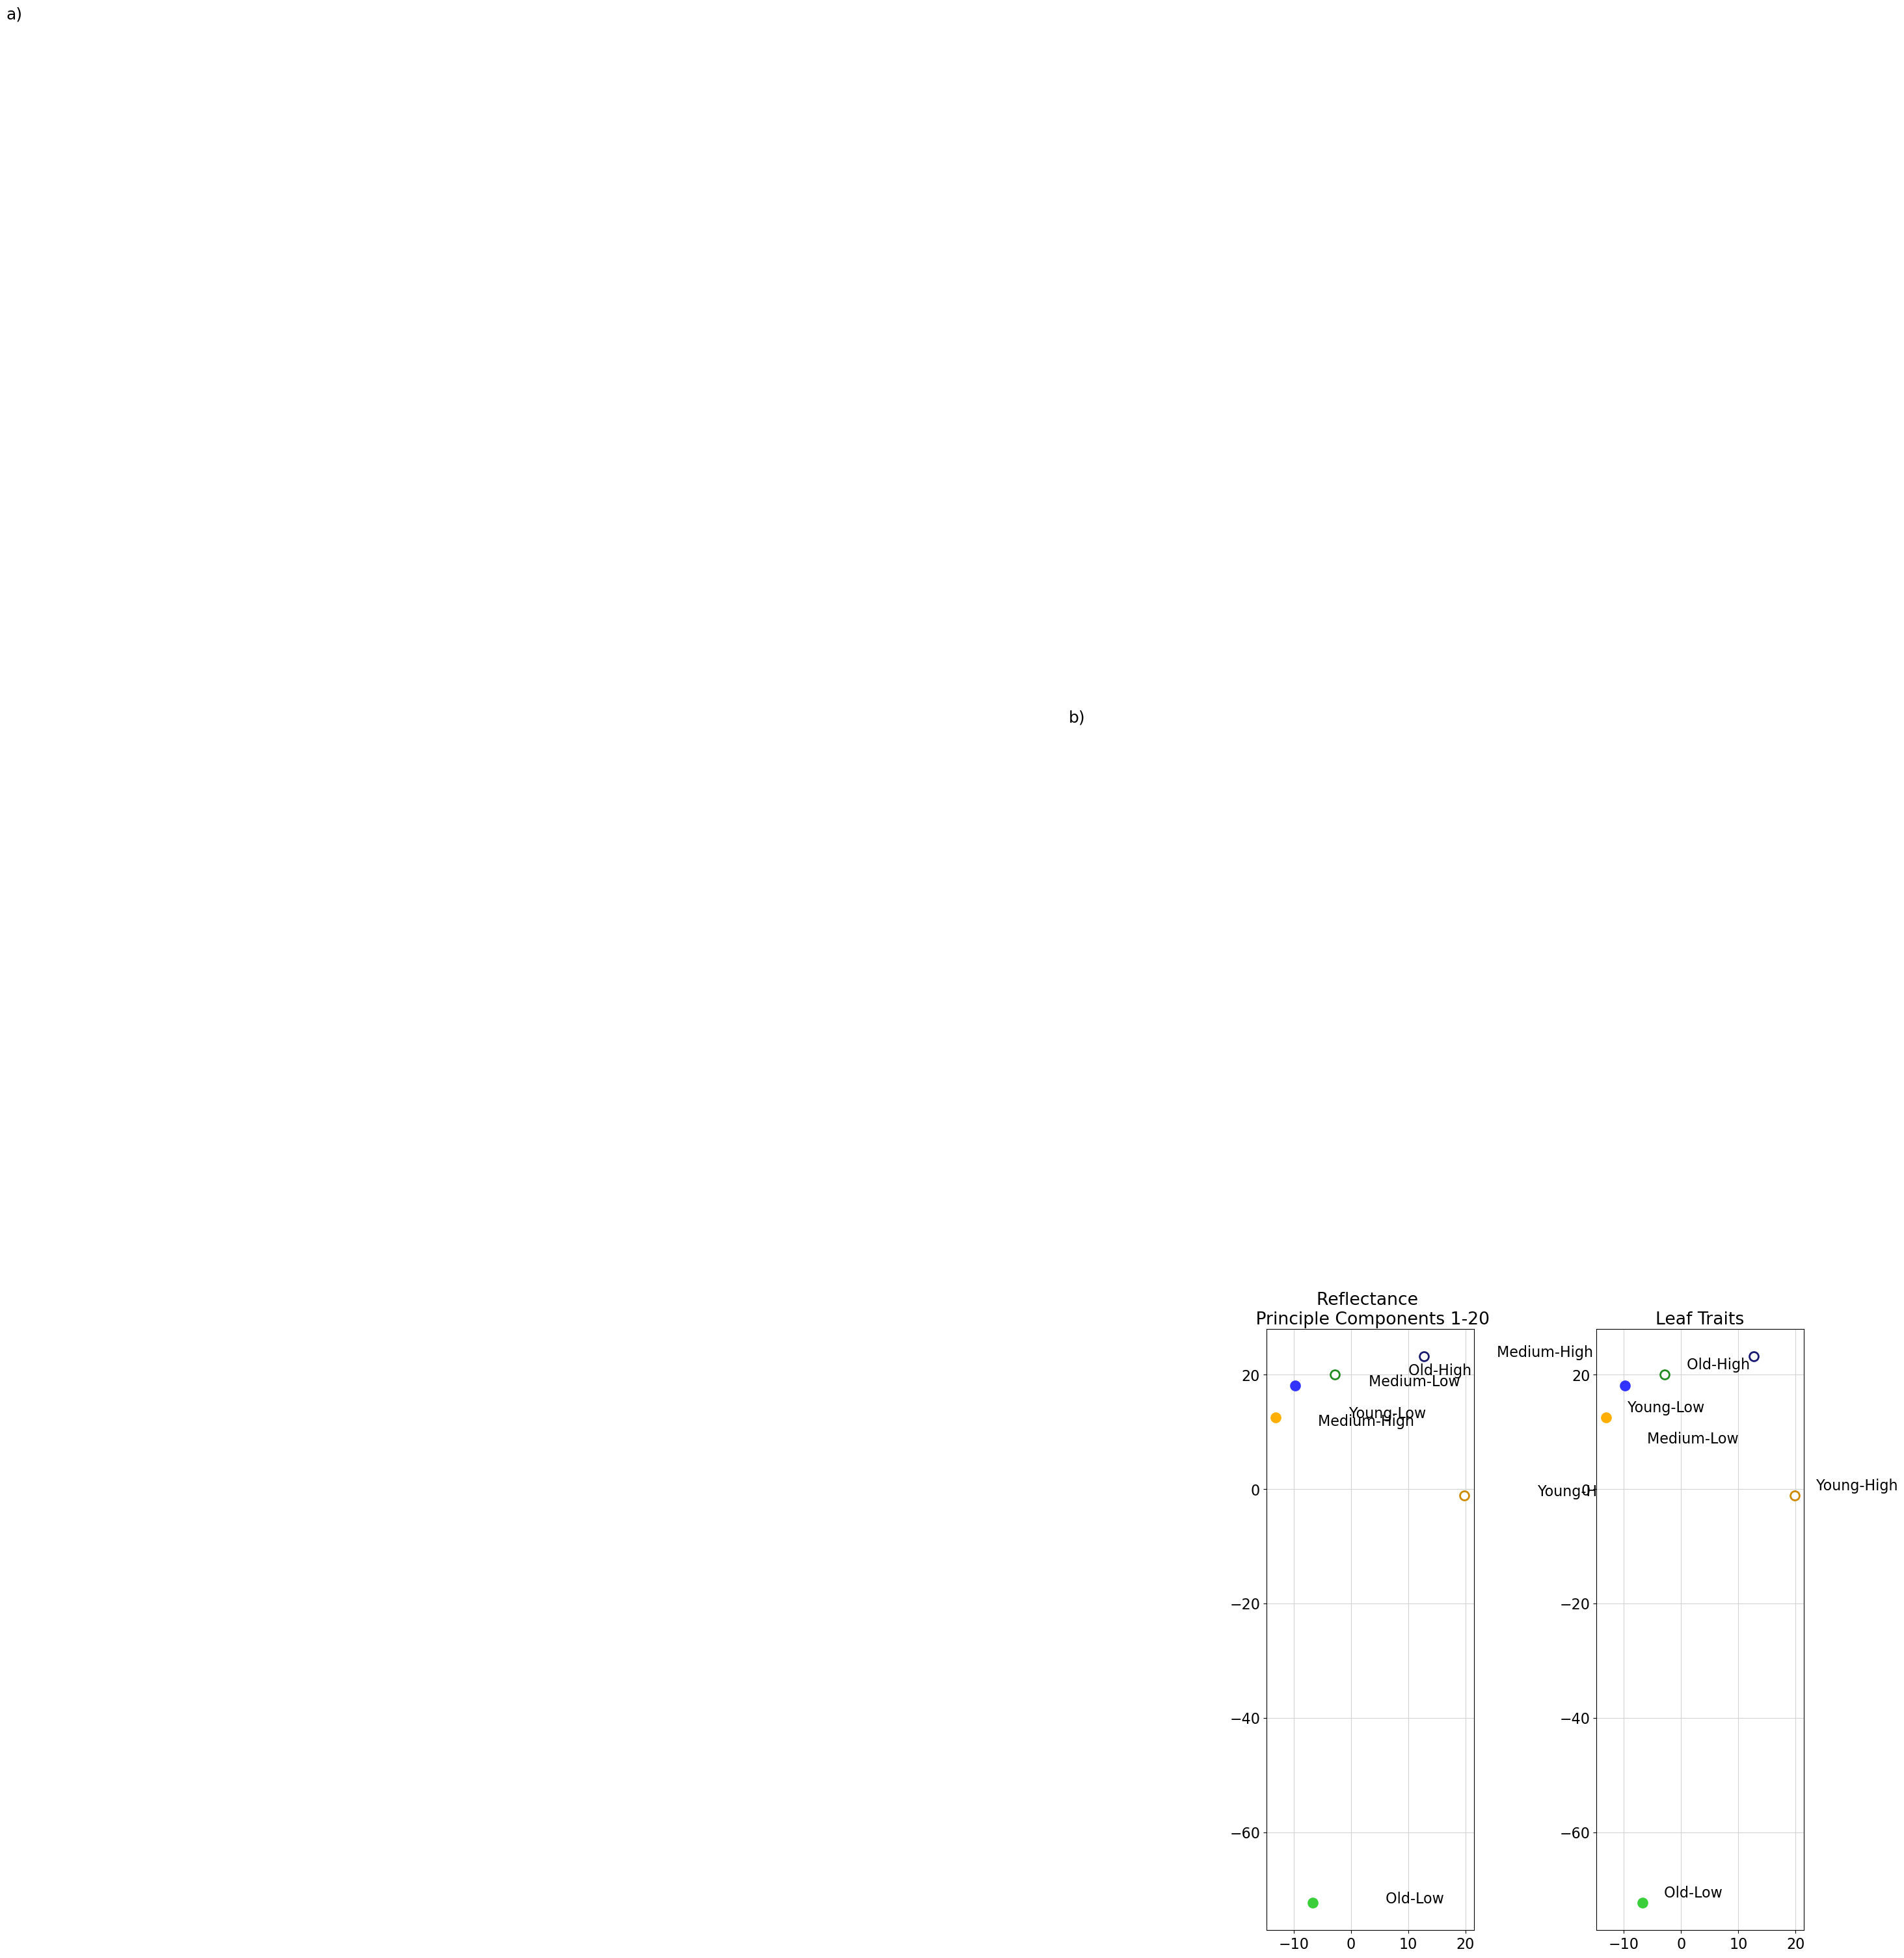

In [54]:
mfc = ['#FFAF01', 'w', '#3333FF', 'w','#3ACF3A','w']


# Modified from code by David R Thompson
import pylab as plt
from sklearn.manifold import MDS

fig, axs = plt.subplots(ncols = 2, figsize = (12,12))

# Define distance matrix
D = np.array([
    [0, 91, 198, 139,74,123],
    [91,0,148,97,126,70],
    [198,148,0,63,255,86],
    [139,97,63,0,199,38],
    [74,126,255,199,0,177],
    [123,70,86,38,177,0]])

# Fit a multidimensional scaling transform (nonlinear)
# Project to two dimensions, preserving interpoint distances
mds = MDS(2, random_state = 10)
x=mds.fit_transform(D)

# Plot the labels
for i,label in enumerate([ ' Young-Low', ' Young-High', ' Medium-Low', ' Medium-High', ' Old-Low', ' Old-High']):
    axs[0].plot(x[i,0],x[i,1],'.', 
                markersize=20, 
                color = cramp[i], 
                markerfacecolor = mfc[i],
               markeredgewidth=2)
    axs[0].text(x[i,0]+12,x[i,1],label)

    
axs[0].set_xlim((-200, 300))
axs[0].set_ylim((-250, 250))
axs[0].set_aspect('equal')
# axs[0].box(True)
axs[0].grid(True, color = 'lightgray')
axs[0].set_title('Reflectance \n Principle Components 1-20')

D = np.array([
    [0, 77, 102, 120,20,58],
    [77,0,126,74,74,41],
    [102,126,0,102,118,89],
    [120,74,102,0,126,64],
    [20,74,118,126,0,63],
    [58,41,89,64,63,0]])
# # Define distance matrix for PC 2-20
# D = np.array([
#     [0,67,19,20,47,35],
#     [67,0,61,60,45,41],
#     [19,61,0,22,35,33],
#     [20,60,22,0,46,32],
#     [47,45,35,46,0,32],
#     [35,41,33,32,32,0]])

# Fit a multidimensional scaling transform (nonlinear)
# Project to two dimensions, preserving interpoint distances
mds = MDS(2, random_state = 10)
x=mds.fit_transform(D)

# Plot the points

# Plot the labels
for i,label in enumerate([ ' Young-Low', ' Young-High', ' Medium-Low', ' Medium-High', ' Old-Low', ' Old-High']):
    axs[1].plot(x[i,0],x[i,1],'.', 
                markersize=20, 
                color = cramp[i],
                markerfacecolor = mfc[i],
               markeredgewidth=2)
    if i == 3:
        axs[1].text(x[i,0]-77,x[i,1]-12,label)
    elif i == 2:
        axs[1].text(x[i,0]+3,x[i,1]-10,label)
    else:
        axs[1].text(x[i,0]+3,x[i,1]+1,label)
    
axs[1].set_xlim((-75, 150))
# axs[1].set_ylim((-80, 55))
axs[1].set_aspect('equal')

axs[1].set_title('Leaf Traits')
# axs[1].set_box(True)
axs[1].grid(False, color = 'lightgray')
axs[0].text(-235,257,'a)', fontsize = 18)
axs[1].text(-107,134,'b)', fontsize = 18)

    
plt.tight_layout()

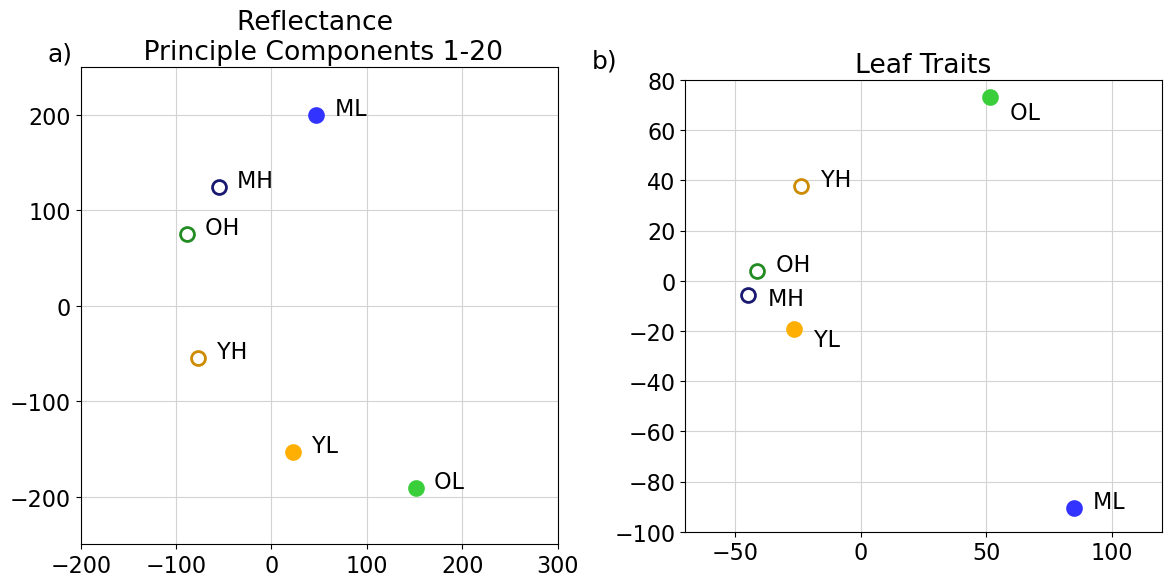

In [76]:
mfc = ['#FFAF01', 'w', '#3333FF', 'w','#3ACF3A','w']
# Modified from code by David R Thompson
import pylab as plt
from sklearn.manifold import MDS
fig, axs = plt.subplots(ncols = 2, figsize = (12,12))
# Define distance matrix
# D = np.array([
#     [0, 91, 198, 139,74,123],
#     [91,0,148,97,126,70],
#     [198,148,0,63,255,86],
#     [139,97,63,0,199,38],
#     [74,126,255,199,0,177],
#     [123,70,86,38,177,0]])
D = np.array([
    [0, 91,198,139, 74,123],
    [91,0,148,97,126,70],
    [198,148,0,63,255,86],
    [139,97,63,0,199,38],
    [74,126,255, 199,0,177],
    [123,70,86,38,177,0]
])
# Fit a multidimensional scaling transform (nonlinear)
# Project to two dimensions, preserving interpoint distances
mds = MDS(2, random_state = 10)
x=mds.fit_transform(D)
# Plot the labels
for i,label in enumerate([ ' YL', ' YH', ' ML', ' MH', ' OL', ' OH']):
    axs[0].plot(x[i,0],x[i,1],'.',
                markersize=20,
                color = cramp[i],
                markerfacecolor = mfc[i],
               markeredgewidth=2)
    axs[0].text(x[i,0]+12,x[i,1],label)
axs[0].set_xlim((-200, 300))
axs[0].set_ylim((-250, 250))
axs[0].set_aspect('equal')
# axs[0].box(True)
axs[0].grid(True, color = 'lightgray')
axs[0].set_title('Reflectance \n Principle Components 1-20')
D = np.array([
    [0, 34, 61, 18,61,14],
    [34,0,90,25,46,22],
    [61,90,0,72,115,72],
    [18,25,72,0,63,10],
    [61,46,115,63,0,55],
    [14,22,72,10,55,0]])
# Fit a multidimensional scaling transform (nonlinear)
# Project to two dimensions, preserving interpoint distances
mds = MDS(2, random_state = 198)
x=mds.fit_transform(D)
# Plot the points
# Plot the labels
for i,label in enumerate([ ' YL', ' YH', ' ML', ' MH', ' OL', ' OH']):
    axs[1].plot(x[i,0],x[i,1],'.',
                markersize=20,
                color = cramp[i],
                markerfacecolor = mfc[i],
               markeredgewidth=2)
    if i == 2:
        axs[1].text(x[i,0]+5,x[i,1],label)
    elif i == 3:
        axs[1].text(x[i,0]+5,x[i,1]-4,label)
    elif i == 0:
        axs[1].text(x[i,0]+5,x[i,1]-7,label)
    elif i == 4:
        axs[1].text(x[i,0]+5,x[i,1]-9,label)
    else:
        axs[1].text(x[i,0]+5,x[i,1],label)
axs[1].set_xlim((-70, 120)) 
axs[1].set_ylim((-100, 80))
axs[1].set_aspect('equal')
axs[1].set_title('Leaf Traits')
# axs[1].set_box(True)
axs[1].grid(False, color = 'lightgray')
axs[0].text(-235,257,'a)', fontsize = 18)
axs[1].text(-107,85,'b)', fontsize = 18)
plt.tight_layout()